In [223]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.feature_extraction.image as skimage
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import time
import networkx as nx

In [2]:
# loading silhouettes and solutions
silhouettes = np.load("silhouettes_adjusted.npy")

## Helper

In [200]:
def crop(silhouette):
    y,x = np.where(silhouette > 0)
    min_y = np.min(y)
    max_y = np.max(y)
    min_x = np.min(x)
    max_x = np.max(x)
    c = silhouette[min_y:max_y+1 , min_x:max_x+1]
    return c

In [201]:
def get_binary_silhouette(silhouette):
    binary = np.copy(silhouette)
    binary[binary>0]=1
    return binary

In [202]:
def place_building_block(bb_id, position):
    x,y = position
    building_blocks = [[(0,0),(1,0),(0,1)],
                       [(0,0),(1,0),(1,1)],
                       [(0,0),(1,0),(1,-1)],
                       [(0,0),(0,1),(1,1)],
                       [(0,0),(1,0),(2,0)],
                       [(0,0),(0,1),(0,2)],
                       []
                      ]
    bb = building_blocks[bb_id]
    return [(x+i, y+j) for (i,j) in bb]

In [203]:
# def get_docking_point(bb_id, position, neighbor_position, neighbor_id):
#     x,y = position
#     s_width, s_height = get_width_height(bb_id)
#     n_width, n_height = get_width_height(neighbor_id)
    
#     mapping = {"left": [(x-s_width, y), (x-n_width,y), (x-n_width+1,y), (x-n_width,y-1), (x-n_width-1,y), (x-n_width+1,y),(x,y)], 
#                "right": [(x+n_width, y), (x+2,y+1), (x+1,y), (x+2,y+1), (x+3,y), (x+1,y+1),(x,y)],
#                "top": [(x, y-s_height),(x,y-n_height), (x+1,y-n_height-1), (x,y-n_height), (x+1,y-n_height), (x,y-n_height),(x,y)], 
#                "bottom": [(x, y+n_height),(x,y+2), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
#     mapping2 = {"left": [(x-3, y+1), (x-3,y+1), (x-1,y), (x-3,y), (x-4,y+1), (x-2,y+1),(x,y)], 
#                "right": [(x+n_width-1, y), (x+n_width-1,y), (x+n_width,y), (x+n_width-1,y), (x+n_width+2,y), (x+n_width,y+1),(x,y)],
#                "top": [(x, y-n_height),(x-1,y-n_height), (x+2,y-n_height-1), (x,y-n_height), (x,y-n_height+1), (x,y-n_height-1),(x,y)], 
#                "bottom": [(x, y+2),(x+1,y+1), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
#     if neighbor_id == 2:
#         print("2")
#         return mapping2[neighbor_position][bb_id]
#     else:
#         return mapping[neighbor_position][bb_id]

In [204]:
# def get_docking_point(bb_id, position, relative_positon, neighbor_id):
#     x,y = position
#     n_width, n_height = get_width_height(neighbor_id)
    
#     mapping = {"left": [(x-n_width, y), (x-n_width,y), (x-n_width,y), (x-n_width,y), (x-n_width,y), (x-n_width,y+1),(x,y)], 
#                "right": [(x+2, y), (x+2,y), (x+1,y), (x+2,y+1), (x+3,y), (x+1,y+1),(x,y)],
#                "top": [(x, y-n_height),(x,y-n_height), (x+1,y-n_height-1), (x,y-n_height), (x+1,y-n_height), (x,y-n_height),(x,y)], 
#                "bottom": [(x, y+2),(x+1,y+2), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
#     mapping2 = {"left": [(x-1, y), (x-1,y), (x-1,y), (x-1,y), (x-1,y), (x-1,y+1),(x,y)], 
#                "right": [(x+2, y), (x+n_width+1,y), (x+n_width,y), (x+n_width+1,y+1), (x+n_width+2,y), (x+n_width,y+1),(x,y)],
#                "top": [(x+1, y-n_height),(x+1,y-n_height), (x+2,y-n_height-1), (x+1,y-n_height), (x+2,y-n_height), (x+1,y-n_height),(x,y)], 
#                "bottom": [(x, y+2),(x+1,y+2), (x,y+1), (x,y+2), (x+1,y+1), (x,y+3),(x,y)]}
    
#     if neighbor_id == 2:
#         return mapping2[neighbor_position][bb_id]
#     else:
#         return mapping[neighbor_position][bb_id]

In [205]:
def get_docking_point(a, b_pos, rel_pos, b):
    # place a next to b
    x,y = b_pos
    a_width, a_height = get_width_height(a)
    b_width, b_height = get_width_height(b)
    
    if b == 0:
        if rel_pos == "left":
            return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y)
        elif rel_pos == "top":
            if a==2:
                return (x, y-1)
            else:
                return (x, y-a_height)
        elif rel_pos == "bottom":
            return (x,y+b_height)
        
        
    if b==1:
        if rel_pos == "left":
            if a == 3:
                return(x-a_width,y-1)
            else:
                return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y)
        elif rel_pos == "top":
            if a==2:
                return (x, y-1)
            else:
                return (x, y-a_height)
        elif rel_pos == "bottom":
            return (x+1,y+b_height)
        
        
    if b==2:
        if rel_pos == "left":
            if a == 3:
                return(x-a_width,y-1)
            else:
                return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y)
        elif rel_pos == "top":
            if a==1:
                return (x, y-a_height-1)
            else:
                return (x+1, y-a_height-1)
        elif rel_pos == "bottom":
            return (x,y+1)
        
        
    if b==3:
        if rel_pos == "left":
            return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y+1)
        elif rel_pos == "top":
            if a == 1:
                return (x-1, y-a_height)
            elif a == 2:
                return (x, y-a_height+1)
            else:
                return (x, y-a_height)
        elif rel_pos == "bottom":
            if a == 2:
                return (x-1,y+b_height+1)
            else:
                return (x,y+b_height)
            
    if b == 4:
        if rel_pos == "left":
            if a == 3:
                return (x-a_width,y-1) 
            else:
                return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y)
        elif rel_pos == "top":
            if a == 1:
                return (x-1, y-a_height)
            elif a == 2:
                return (x, y-a_height+1)
            else: 
                return (x, y-a_height)
        elif rel_pos == "bottom":
            if a == 2:
                return (x-1,y+b_height+1)
            else:
                return (x,y+b_height)
            
    if b == 5:
        if rel_pos == "left":
            if a == 3:
                return(x-a_width,y-1)
            else:
                return(x-a_width,y)
        elif rel_pos == "right": 
            return (x+b_width,y)
        elif rel_pos == "top":
            if a == 1:
                return (x-1, y-a_height)
            elif a == 2:
                return (x, y-a_height+1)
            else:
                return (x, y-a_height)
        elif rel_pos == "bottom":
            if a==2:
                return (x-1,y+b_height+1)
            else:
                return (x,y+b_height)
            
            
        
    

In [206]:
def get_width_height(bb_id):
    building_blocks = [(2,2), (2,2), (2,2), (2,2), (3,1), (1,3),(0,0)]
    return building_blocks[bb_id]

In [207]:
def fill_pixel(scene, pixel):
    for p in pixel:
        scene[p[1], p[0]] = 1
    

In [262]:
def draw_silhouette(edges,positions):
    placed = []
    scene = np.zeros((20,20))
    if len(edges) == 0:
        return scene
    
#     for i in range(len(edges)):
#         print("  - ", edges[i], positions[i])

    for i in range(len(edges)):
        if edges[i][1] == 6:
            edges[i]= (edges[i][0], edges[i][0])
            
    
    
    pos = (7,7)
    receiver = edges[0][1]
    fill_pixel(scene, place_building_block(receiver,pos))
    placed.append(receiver)
    
    next_block = []
    next_pos = []
    
    while True:
        for i,e in enumerate(edges):
            if e[1] ==receiver:
                sender = e[0]
                if sender not in placed:
                    n = get_docking_point(sender, pos, positions[i], receiver)
                    fill_pixel(scene, place_building_block(sender,n))
                    placed.append(sender)
                    if sender not in next_block:
                        next_block.append(sender)
                        next_pos.append(n)
        if len(next_block) == 0:
            break
        receiver = next_block.pop()
        pos = next_pos.pop()
        
    return scene
    

In [263]:
# for a in range(6):
#     #for b in range(6):
#     for pos in ["left", "right", "top", "bottom"]:
#         scene = draw_silhouette([(a,5)],[pos])
#         plt.imshow(scene)
#         plt.show()

## Environment

In [316]:
class Env():
    def __init__(self, silhouettes):
        self.silhouettes = silhouettes
        self.current_silhouette = None
        self.num_actions = 0
        self.current_graph = []
        self.edges = []
        self.positions = []
    
    def reset(self):
        idx = random.randint(0,len(self.silhouettes)-1)
        self.current_silhouette = self.silhouettes[idx]
        self.num_actions = 0
        vertices = [[i,0] for i in range(6)]
        vertices.append([6,1]) # initial block for placing the first block in an empty scene
        self.edges = []
        self.current_graph = [vertices, [], get_binary_silhouette(self.current_silhouette)]
        self.current_graph[1] = self.get_valid_edges()
        self.positions = []
        return np.copy(self.current_graph)
    
    def get_valid_edges(self):
        edges = []
        for sender in range(7):
            for receiver in range(7):
                if sender == 6:
                    continue
                if receiver == 6 and len(self.edges) > 0:
                    continue
                if self.current_graph[0][sender][1] == 0 and self.current_graph[0][receiver][1]==1:
                    edges.append((sender,receiver,np.zeros(4)))
        return edges
        
    def one_hot(self, index):
        a = np.zeros(4)
        a[index] = 1
        return a
    
    
    def step(self, action, verbose = False):
        if verbose:
            print("T = ", self.num_actions)
            self.draw_graph()
        
        self.num_actions += 1
        sender, receiver, rel_position = action
        if verbose:
            if receiver == 6:
                print("Place: ", sender)
            else: 
                print("Place: ", sender, " next to ", receiver, "position: ", ["left", "right", "top", "bottom"][rel_pos])

        action_idx = sender*28+receiver*4+rel_position
        done = self.num_actions >= 3
        reward = 0
        if self.valid(sender, receiver, rel_position):
            self.positions.append(["left", "right", "top", "bottom"][rel_position])
            # place sender in scene 
            self.current_graph[0][sender][1] = 1
            
            # save edge
            self.edges.append((sender,receiver, self.one_hot(rel_position)))
            # oposite edges
            if (receiver != 6):
                if rel_position % 2 == 0:
                    rel_pos_op = rel_position +1 
                else:
                    rel_pos_op = rel_position -1

                self.edges.append((receiver,sender, self.one_hot(rel_pos_op)))
                self.positions.append(["left", "right", "top", "bottom"][rel_pos_op])
            
            
            self.current_graph[1] =  np.concatenate((self.edges, self.get_valid_edges())) 
            if len(self.edges):
                # draw blocks
                draw_edges = [(e[0], e[1]) for e in self.edges]
                draw_pos = [self.positions[i] for i in range(len(self.positions))]
                if len(draw_edges) > 0:
                    scene = draw_silhouette(draw_edges, draw_pos)
                    if verbose:
                        print("Scene after move: ")
                        plt.imshow(scene)
                        plt.show()
                    sil_crop = crop(self.current_silhouette)
                    scene_crop = crop(scene)
                    pixel_coordinates = np.argwhere(sil_crop == 1)
                    # calculate overlap
                    
                    if verbose:
                        fig = plt.figure(figsize=(12,8))
                        fig.add_subplot(1,2,1)
                        plt.imshow(sil_crop)
                        fig.add_subplot(1,2,2)
                        plt.imshow(scene_crop)
                        plt.show()
                        
                    
                    for p in pixel_coordinates:
                        if scene_crop.shape[0] > p[0] and scene_crop.shape[1] > p[1]: 
                            if scene_crop[p[0], p[1]] == 1:
                                if receiver != 6:
                                    reward += 1
                                    
            else:
                # invalid move
                reward = -1
                                    
#         if  not done:
#             reward = 0
            
        return np.copy(self.current_graph), reward, done
            
        
    def valid(self, sender, receiver, rel_position):
        # sender has to be available, receiver has to be placed
        if self.current_graph[0][sender][1] == 1 or self.current_graph[0][receiver][1] == 0:
            return False
        # get all edges to the receiver
        e_r = [e for e in self.edges if e[1] == receiver] 
        for e in e_r:
            # if any other block is connected to the receiver with the same relative position, this action is illegal
            if e[2][rel_position] == 1:
                return False
        return True
        
        
        
    def draw_graph(self):
        if len(self.edges) > 0:
            possible_edges = [(e[0], e[1]) for e in np.concatenate((self.edges, self.get_valid_edges())) ]
            set_edges = [(e[0], e[1]) for e in self.edges]
        else:
            possible_edges = [(e[0], e[1]) for e in self.get_valid_edges()]
            set_edges = []
        values = list(range(0,7))
        
        G = nx.DiGraph()
        G.add_edges_from(possible_edges)
        pos = nx.spring_layout(G)


        edge_colours = ['black' if not edge in set_edges else 'red'
                        for edge in G.edges()]
        next_edges = [edge for edge in G.edges() if edge not in set_edges]


        nx.draw_networkx_nodes(G, pos, node_color = values, node_size = 500, cmap=plt.get_cmap('jet'))
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, edgelist=set_edges, edge_color='r')
        nx.draw_networkx_edges(G, pos, edgelist=next_edges)

        plt.show()


## DQN

In [317]:
class DeepQNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('cpu')
        self.num_iterations = 1
        lr = 0.0003
        
        self.relu = nn.ReLU().to(self.device)
        self.global_embedding_conv1 = nn.Conv2d(in_channels=1, out_channels=4, stride=2, kernel_size=4, padding=2).to(self.device)
        self.global_embedding_conv2 = nn.Conv2d(in_channels=4, out_channels=5, stride=2, kernel_size=3).to(self.device)
        self.global_embedding_fc1 = nn.Linear(20, 16).to(self.device)
        self.global_embedding_fc2 = nn.Linear(16, 4).to(self.device)
        
        self.vertices_embedding_fc1 = nn.Linear(2, 8).to(self.device)
        self.vertices_embedding_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.edges_embedding_fc1 = nn.Linear(4, 8).to(self.device)
        self.edges_embedding_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.edges_fc1 = nn.Linear(4*4, 8).to(self.device)
        self.edges_fc2 = nn.Linear(8, 4).to(self.device)
        
        self.vertices_fc1 = nn.Linear(3*4, 8).to(self.device)
        self.vertices_fc2 = nn.Linear(8, 4).to(self.device)


        self.edges_decode_fc1 = nn.Linear(4, 8).to(self.device)
        self.edges_decode_fc2 = nn.Linear(8, 4).to(self.device)
        
        
        # optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.to(self.device)


    def forward(self, g, verbose=False):
        V,E,U = g
        edges_copy = np.copy(E)
        V = torch.tensor(V).float().to(self.device)
        E = torch.tensor([e[2] for e in E]).float().to(self.device)
        U = torch.tensor(U).reshape((1,1,10,10)).float().to(self.device)
        #A = torch.tensor(A).float().to(self.device)#1 hot taken actions
        
        # encoding vertices embedding
        V = self.relu(self.vertices_embedding_fc1(V))
        V = self.vertices_embedding_fc2(V)
        
        # encoding edges embedding 
        E = self.relu(self.edges_embedding_fc1(E))
        E = self.edges_embedding_fc2(E)
        
        # encoding global embedding
        U = self.global_embedding_conv1(U)
        U = self.global_embedding_conv2(U)
        U = torch.flatten(U) 
        U = self.relu(self.global_embedding_fc1(U))
        U = self.global_embedding_fc2(U)
        
        for k in range(self.num_iterations):
            # Update edges
            edges = torch.empty((len(E),4*4))
            for i,e in enumerate(E):
                sender = edges_copy[i][0]
                receiver = edges_copy[i][1]
                edges[i] = torch.cat((e,V[sender], V[receiver], U)) 
                #edges.append(e)
            E = edges.to(self.device)
            E = self.relu(self.edges_fc1(E))
            E = self.edges_fc2(E)
            
            # Update vertices
            vertices = torch.empty((len(V),3*4))
            if verbose:
                print("\nIncoming Edges per node: ")
            for i,v in enumerate(V):
                edges_in = [E[j].clone() for j in range(len(E)) if edges_copy[j][1] == i]
                if verbose:
                    print("Node: ", i)
                    for e in edges_in:
                        print("  - ", e)
                #print("EDGES IN: ", edges_in)
                if len(edges_in) == 0:
                    e_accum = torch.zeros(4)
                else:
                    edges_in = torch.stack(edges_in, dim=0)
                    e_accum = torch.sum(edges_in, axis=0)
                vertices[i] = torch.cat((v,e_accum,U))
            V = vertices.to(self.device)   
            V = self.relu(self.vertices_fc1(V))
            V = self.vertices_fc2(V)
            
        
        # decode q_values
        E = self.relu(self.edges_decode_fc1(E))
        q_values = self.edges_decode_fc2(E)
        
#         q_min = torch.min(q_values)
#         for i in range(len(edges_copy)):
#             if np.sum(edges_copy[i][2]) > 0:
#                 q_values[i] = q_min
                
        return q_values

In [318]:
class Agent():
    def __init__(self) -> None:
        self.max_memory = 10000 
        self.eps_end = 0.01 
        self.eps_dec = 5e-5
        self.batch_size = 16
        self.Q_eval = DeepQNetwork()
        self.epsilon = 1
        self.gamma = 0.99
        
        self.loss = []
        self.memory = []

    def store_transition(self, state, action, reward, next_state, done):
        if len(self.memory) >= self.max_memory:
            del self.memory[0]
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, verbose):
        #print("epsilon: ", self.epsilon)

        if random.uniform(0, 1) > self.epsilon:
            if verbose:
                print("Maximize Reward")
            q_vals = self.Q_eval.forward(state, verbose).cpu().detach().numpy().flatten()
            action = np.argmax(q_vals)
            edge = state[1][action//4]
            sender = edge[0]
            receiver = edge[1]
            rel_pos = action%4
        else:
            if verbose:
                print("Take random action")
            edges = state[1]
            valid_edges = [e for e in edges if np.sum(e[2])==0]
            i = np.random.choice(np.arange(len(valid_edges)))
            edge = valid_edges[i]
            sender = edge[0]
            receiver = edge[1]
            rel_pos = np.random.choice(np.arange(4))
        
        return sender, receiver, rel_pos

    
    def save(self, path):
        torch.save(self.Q_eval, path)
        
    def load(self, path):
        self.Q_eval = torch.load(path)
        self.Q_eval.eval()
    
    def learn(self, verbose=False):
        if verbose:
            print("TRAIN")
        
        # gather at least one batch of observations
        if len(self.memory) < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        
        
        rewards = torch.zeros((self.batch_size))
        dones = torch.zeros((self.batch_size))
        q_eval = torch.zeros((self.batch_size))
        q_next = torch.zeros((self.batch_size))
        
        
        rew_0 = [i for i in self.memory if i[2] == 0]
        rew_1 = [i for i in self.memory if i[2] != 0]
        #print("\nMemory:")
        #print("  reward 0: ", len(rew_0), "  --> ", len(rew_0)/len(self.memory))
        #print("  reward 1: ", len(rew_1), "  --> ", len(rew_1)/len(self.memory))
        
        
#         print("REWARD 0: ")
#         print(rew_0)
        
#         print("REWARD 1: ")
#         print(rew_1)
        
        if len(rew_0)==0:
            batch_indices_0 = np.random.choice(len(rew_1), int(self.batch_size/2), replace=True)
            batch_indices_1 = np.random.choice(len(rew_1), int(self.batch_size/2), replace=True)
        elif len(rew_1)==0:
            batch_indices_0 = np.random.choice(len(rew_0), int(self.batch_size/2), replace=True)
            batch_indices_1 = np.random.choice(len(rew_0), int(self.batch_size/2), replace=True)
        else:
            batch_indices_0 = np.random.choice(len(rew_0), int(self.batch_size/2), replace=True)
            batch_indices_1 = np.random.choice(len(rew_1), int(self.batch_size/2), replace=True)
        
        
        for i,idx in enumerate(batch_indices_0): 
            (state, action, reward, next_state, done) = self.memory[idx]
            q_eval[i] = self.Q_eval.forward(state).flatten()[action]
            q_next[i] = torch.max(self.Q_eval.forward(next_state).flatten()).item()
            rewards[i] = reward
            dones[i] = done
            
       
            
        for i,idx in enumerate(batch_indices_1):
            i+=int(self.batch_size/2)
            (state, action, reward, next_state, done) = self.memory[idx]
            q_eval[i] = self.Q_eval.forward(state, verbose).flatten()[action]
            q_next[i] = torch.max(self.Q_eval.forward(next_state, verbose).flatten()).item()
            rewards[i] = reward
            dones[i] = done
        
#         rewards = torch.tensor(rewards)
#         dones = torch.tensor(dones)
#         q_eval = torch.tensor(q_eval)
#         q_next = torch.tensor(q_next)
        
        q_target = rewards + self.gamma * (1.0-dones) * q_next

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        self.loss.append(loss.item())
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_end else self.eps_end
        
        
    def plot_q_values(self, state):
        q_vals = self.Q_eval.forward(state).cpu().detach().numpy().flatten()
        print("\n\nTop 10 Q-Values: ")
        indices = q_vals.argsort()[::-1]
        for i in indices:
            sender = i // 28
            receiver = (i-sender*28) // 4
            rel_pos = i % 4
            print("  -(",sender, receiver, rel_pos,") : ",q_vals[i])
            #print("  -",i,": ",q_val[i])
        print("\n\n")
        
        
#         print(q_val)
#         plt.bar(list(range(len(q_val))),q_val)
#         plt.show()


# Train

In [322]:
agent = Agent()
n_games = 2000
eps_decay = 1/round(n_games*0.9)
agent.eps_dec = eps_decay
reward_history = []
stat = []
env = Env(silhouettes)
start_time = time.time()
filename = 'train/train_dqn.txt'
file = open(filename, 'w')
file.write("##########################################\n")
file.write("n_games = " + str(n_games)+"\n")
file.write("batch_size = " +  str(agent.batch_size) +"\n")
file.write("eps_decay = " + str(agent.eps_dec) + "\n")
file.write("buffer_size = " +str(agent.max_memory) + "\n")
file.write("##########################################\n\n\n")
file.close()
verbose = False

# Test
#agent.epsilon = 0


for i in range(n_games):
    state = env.reset()
    done = False
    total_reward = 0
    
    #print("\n\n\n ### GAME ", i," ###")
    #plt.imshow(state[2])
    #plt.show()
    
    while not done:
        sender,receiver,rel_pos = agent.choose_action(state, verbose)

        next_state,reward,done = env.step((sender,receiver,rel_pos), verbose)
#         print(" --> Reward: ", reward)
        total_reward += reward
        action = 0
        for idx,edge in enumerate(state[1]):
            if edge[0] == sender and edge[1] == receiver:
                action = idx * 4 + rel_pos
        agent.store_transition(state, action, reward, next_state, done)
        agent.learn(verbose=False)
        state = next_state
        
    stat.append(total_reward)
    if i % 50==0 and i > 0:
        print("Game #", i, "reward: ", round(np.mean(stat),2), "   eps: ",round(agent.epsilon,2), "time: ",round(time.time()-start_time, 2))
        file = open(filename, 'a')
        file.write("Game #" + str(i) +  "  reward: " + str(np.mean(stat)) + "   eps: " + str(agent.epsilon) + "  time: " + str(round(time.time()-start_time, 2))+"\n")
        file.close()
        
        if i % 1000==0 and i > 0:
            model_path = "train/model_"+str(i)+"_"+str(np.mean(stat))+".pt"
            agent.save(model_path)
            
        reward_history.append(np.mean(stat))
        stat = []
        start_time = time.time()

        

Game # 50 reward:  6.69    eps:  0.92 time:  10.23
Game # 100 reward:  5.96    eps:  0.84 time:  11.13
Game # 150 reward:  5.7    eps:  0.76 time:  10.57
Game # 200 reward:  4.54    eps:  0.67 time:  10.53
Game # 250 reward:  4.24    eps:  0.59 time:  10.38
Game # 300 reward:  3.66    eps:  0.51 time:  10.63
Game # 350 reward:  3.42    eps:  0.42 time:  10.34
Game # 400 reward:  2.88    eps:  0.34 time:  10.52
Game # 450 reward:  2.38    eps:  0.26 time:  10.67
Game # 500 reward:  1.24    eps:  0.17 time:  10.47
Game # 550 reward:  0.4    eps:  0.09 time:  10.37
Game # 600 reward:  0.52    eps:  0.01 time:  10.53
Game # 650 reward:  0.0    eps:  0.01 time:  10.5
Game # 700 reward:  0.16    eps:  0.01 time:  10.37
Game # 750 reward:  0.04    eps:  0.01 time:  10.27
Game # 800 reward:  0.14    eps:  0.01 time:  10.9
Game # 850 reward:  0.0    eps:  0.01 time:  11.98
Game # 900 reward:  0.06    eps:  0.01 time:  10.41
Game # 950 reward:  0.04    eps:  0.01 time:  9.97
Game # 1000 reward: 

Reward history


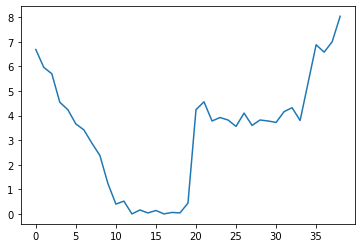

Loss history


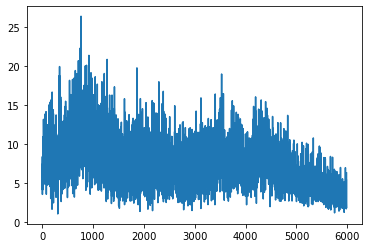

Q-values


Top 10 Q-Values: 
  -( 0 5 0 ) :  2.6969905
  -( 0 6 0 ) :  2.625679
  -( 1 0 0 ) :  2.6030688
  -( 0 5 1 ) :  2.5929546
  -( 0 5 3 ) :  2.5582898
  -( 1 1 0 ) :  2.550089
  -( 0 6 1 ) :  2.5182118
  -( 1 0 1 ) :  2.502552
  -( 0 6 3 ) :  2.4953694
  -( 1 4 0 ) :  2.4821548
  -( 1 0 3 ) :  2.4804285
  -( 1 2 0 ) :  2.478778
  -( 1 3 0 ) :  2.4561675
  -( 1 1 1 ) :  2.4560194
  -( 1 1 3 ) :  2.4394395
  -( 1 5 0 ) :  2.4108436
  -( 1 4 1 ) :  2.3982897
  -( 1 6 0 ) :  2.3882332
  -( 1 4 3 ) :  2.3880134
  -( 1 2 1 ) :  2.3812766
  -( 1 2 3 ) :  2.3765194
  -( 1 3 1 ) :  2.3656173
  -( 1 3 3 ) :  2.3615782
  -( 1 5 3 ) :  2.325093
  -( 1 5 1 ) :  2.323547
  -( 1 6 3 ) :  2.3101523
  -( 1 6 1 ) :  2.307887
  -( 0 5 2 ) :  2.2794676
  -( 0 6 2 ) :  2.2081373
  -( 1 0 2 ) :  2.201379
  -( 1 1 2 ) :  2.1680493
  -( 1 4 2 ) :  2.1281881
  -( 1 2 2 ) :  2.0967193
  -( 1 3 2 ) :  2.0899613
  -( 0 2 0 ) :  2.0824792
  -( 1 5 2 ) :  2.0568578
  -( 0 1 0 ) :  2.0564008
  -( 1 6 2 ) :  2

In [323]:
print("Reward history")
plt.plot(reward_history)
plt.show()

print("Loss history")
plt.plot(agent.loss)
plt.show()

print("Q-values")
agent.plot_q_values(state)

# Test



  ###  Test  0  ###
Silhouette


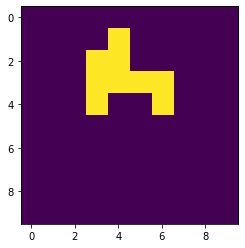

T =  0


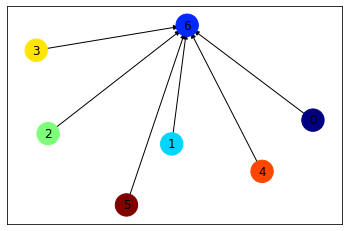

Place:  1
Scene after move: 


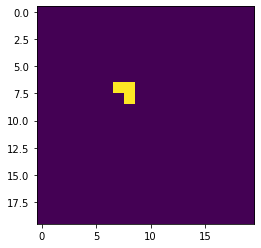

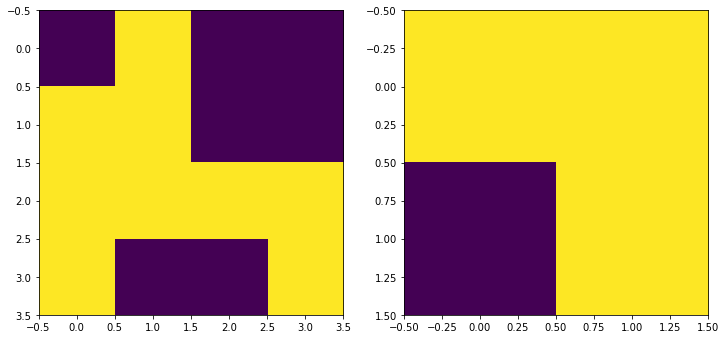

  --> reward:  0
T =  1


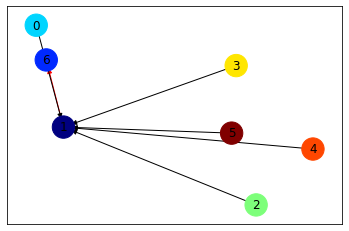

Place:  0  next to  1 position:  left
Scene after move: 


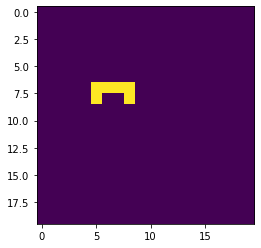

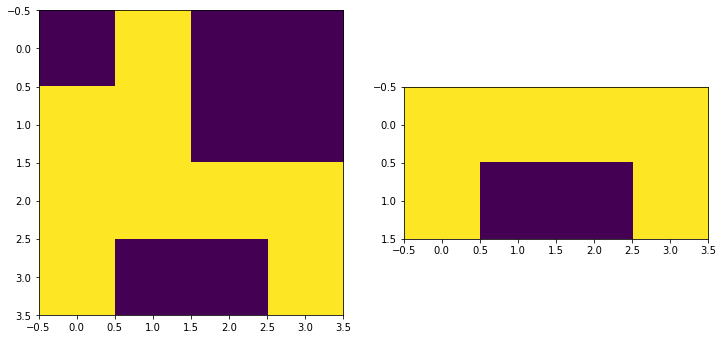

  --> reward:  2
T =  2


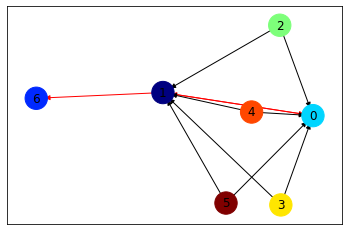

Place:  2  next to  0 position:  left
Scene after move: 


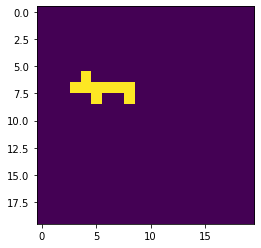

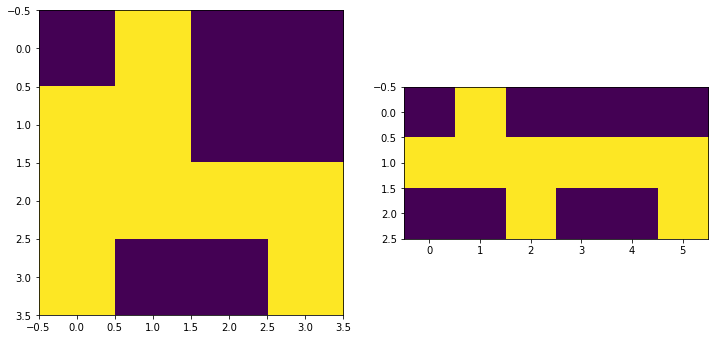

  --> reward:  4


  ###  Test  1  ###
Silhouette


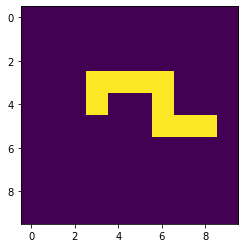

T =  0


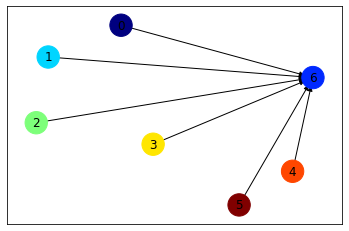

Place:  1
Scene after move: 


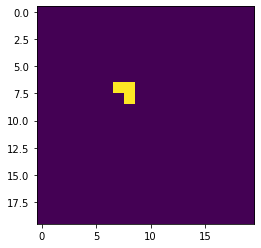

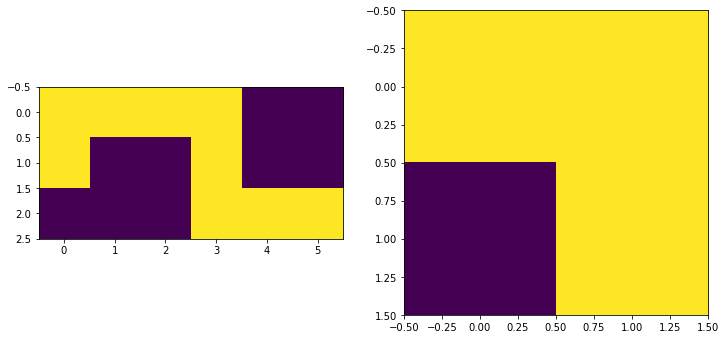

  --> reward:  0
T =  1


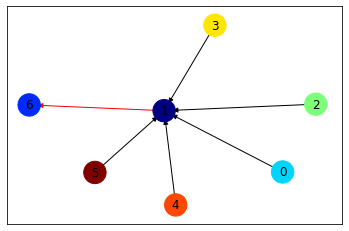

Place:  0  next to  1 position:  left
Scene after move: 


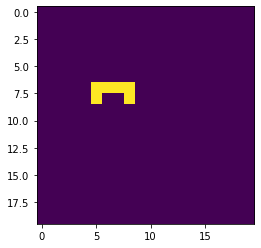

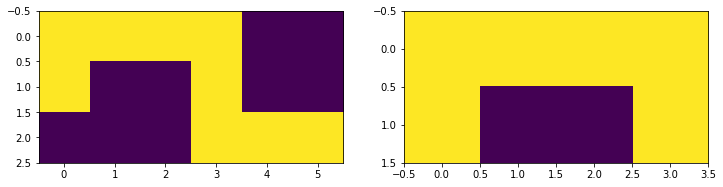

  --> reward:  6
T =  2


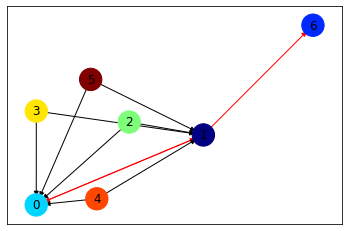

Place:  2  next to  0 position:  left
Scene after move: 


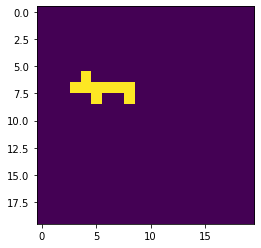

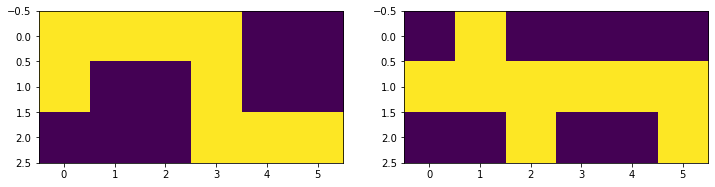

  --> reward:  4


  ###  Test  2  ###
Silhouette


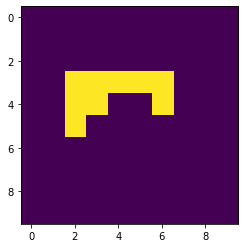

T =  0


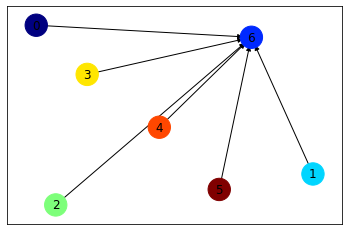

Place:  1
Scene after move: 


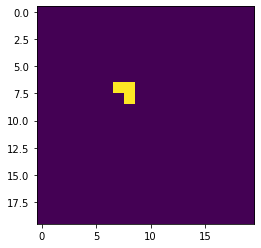

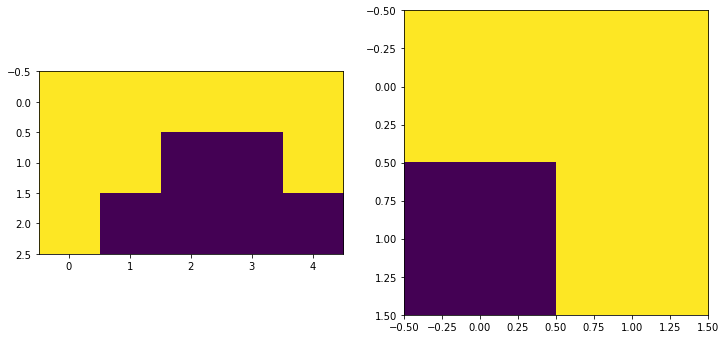

  --> reward:  0
T =  1


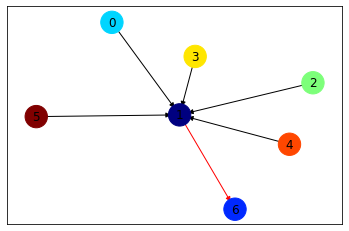

Place:  0  next to  1 position:  left
Scene after move: 


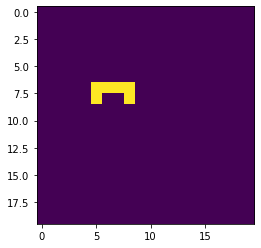

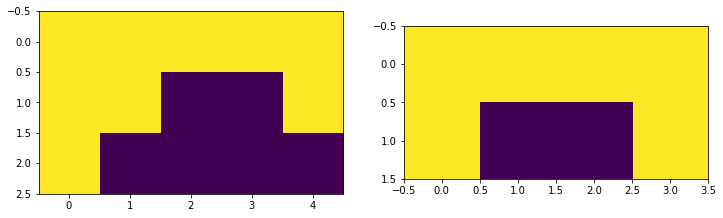

  --> reward:  5
T =  2


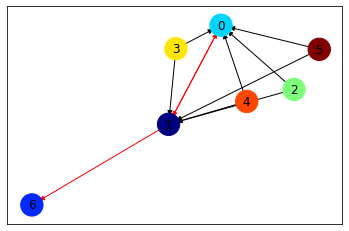

Place:  2  next to  0 position:  left
Scene after move: 


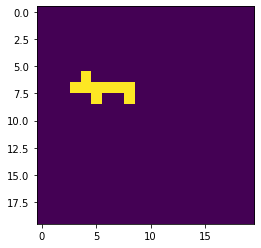

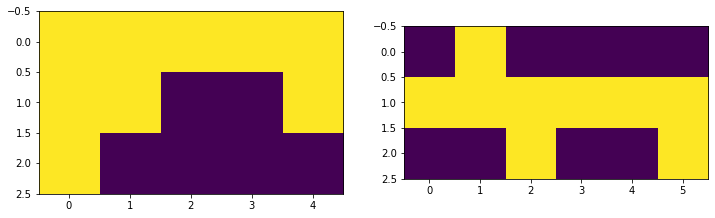

  --> reward:  4


  ###  Test  3  ###
Silhouette


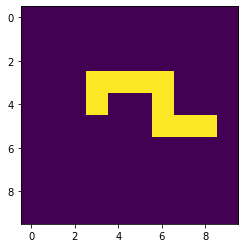

T =  0


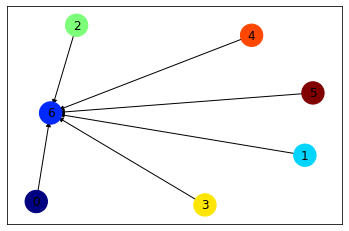

Place:  1
Scene after move: 


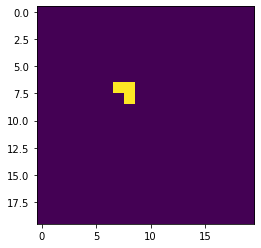

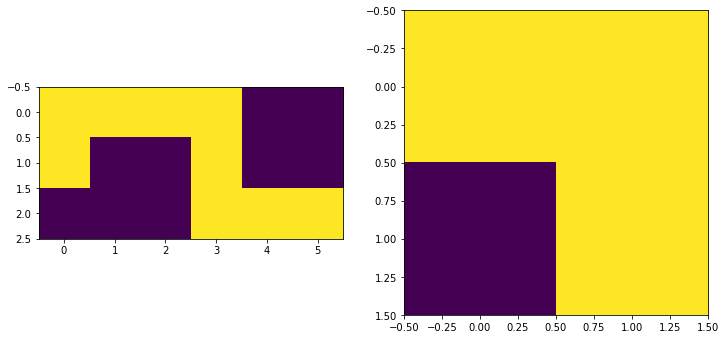

  --> reward:  0
T =  1


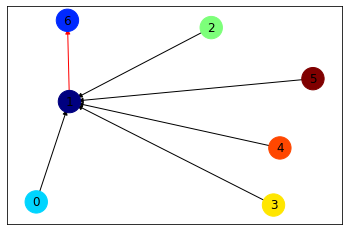

Place:  0  next to  1 position:  left
Scene after move: 


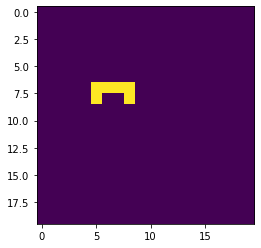

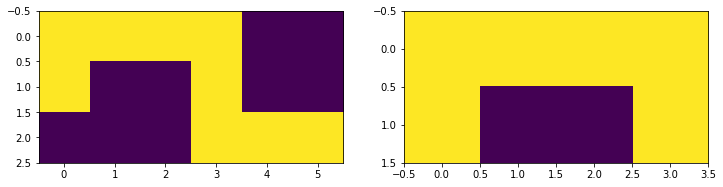

  --> reward:  6
T =  2


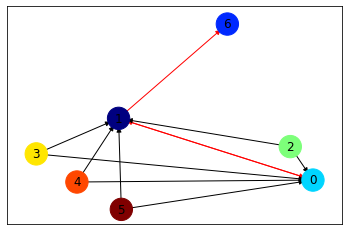

Place:  2  next to  0 position:  left
Scene after move: 


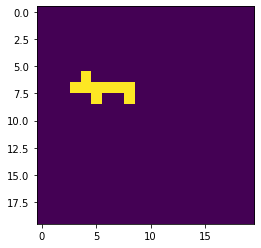

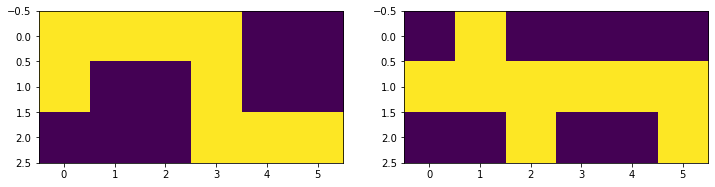

  --> reward:  4


  ###  Test  4  ###
Silhouette


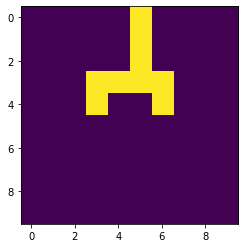

T =  0


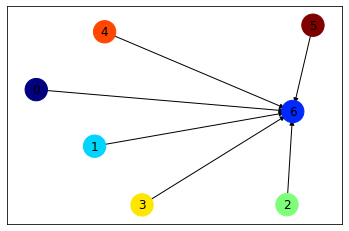

Place:  1
Scene after move: 


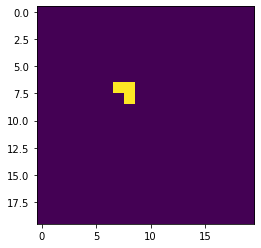

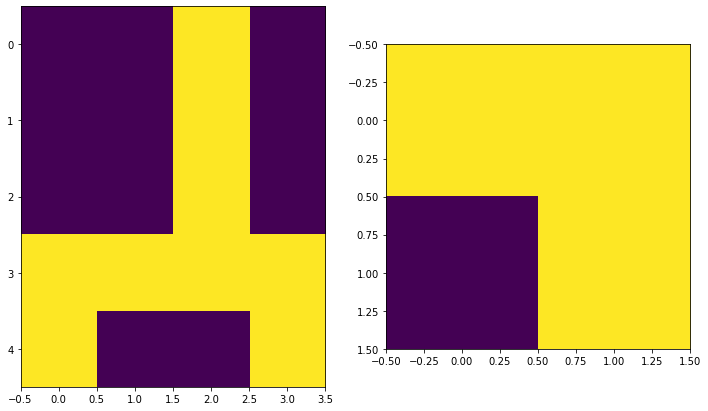

  --> reward:  0
T =  1


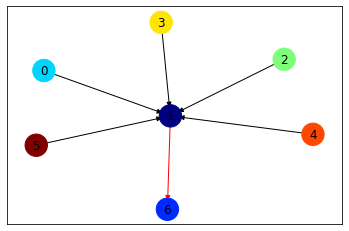

Place:  0  next to  1 position:  left
Scene after move: 


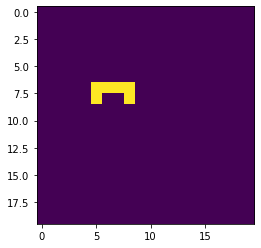

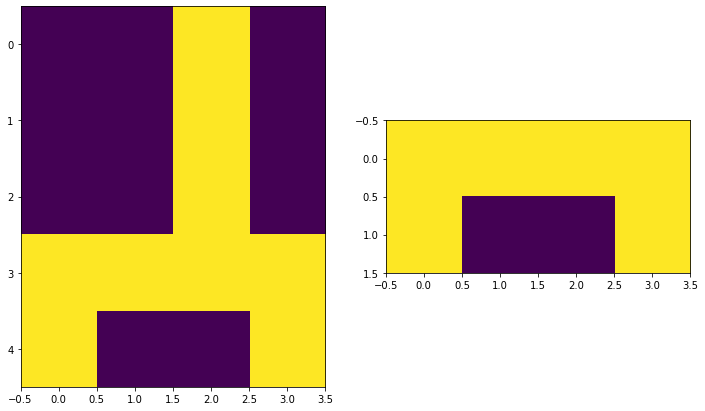

  --> reward:  1
T =  2


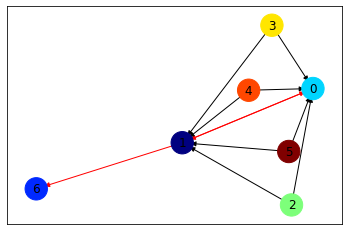

Place:  2  next to  0 position:  left
Scene after move: 


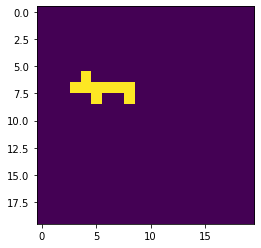

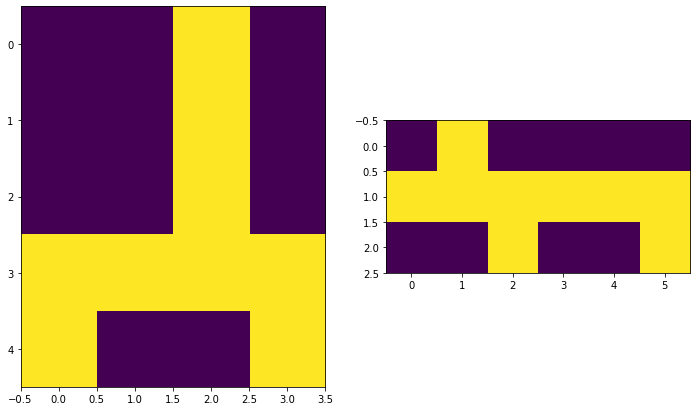

  --> reward:  2


  ###  Test  5  ###
Silhouette


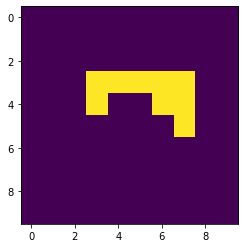

T =  0


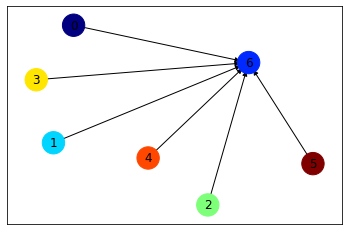

Place:  1
Scene after move: 


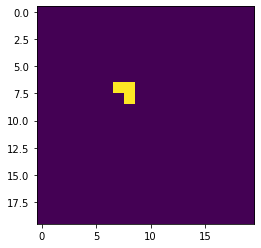

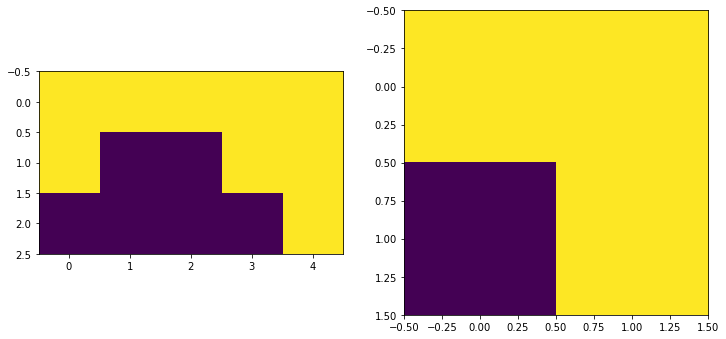

  --> reward:  0
T =  1


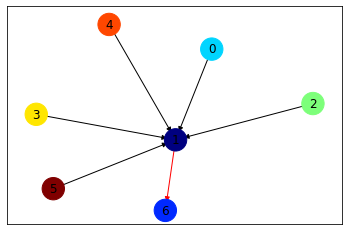

Place:  0  next to  1 position:  left
Scene after move: 


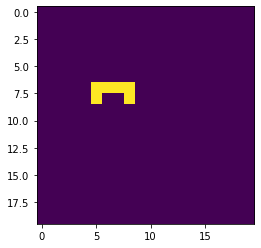

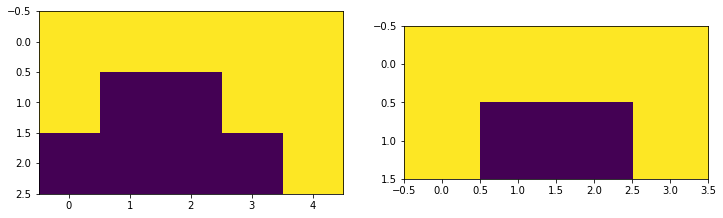

  --> reward:  6
T =  2


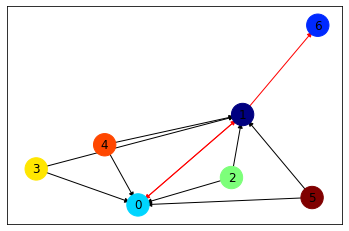

Place:  2  next to  0 position:  left
Scene after move: 


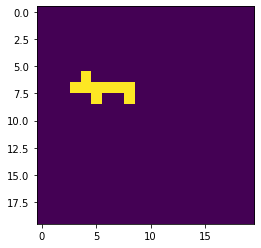

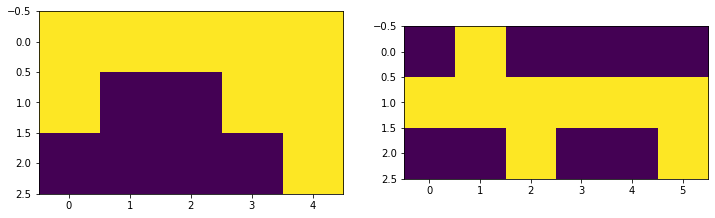

  --> reward:  4


  ###  Test  6  ###
Silhouette


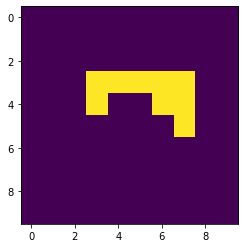

T =  0


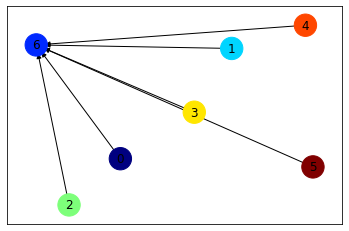

Place:  1
Scene after move: 


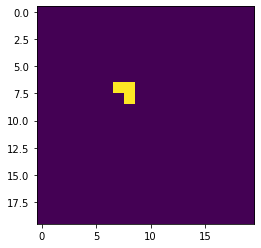

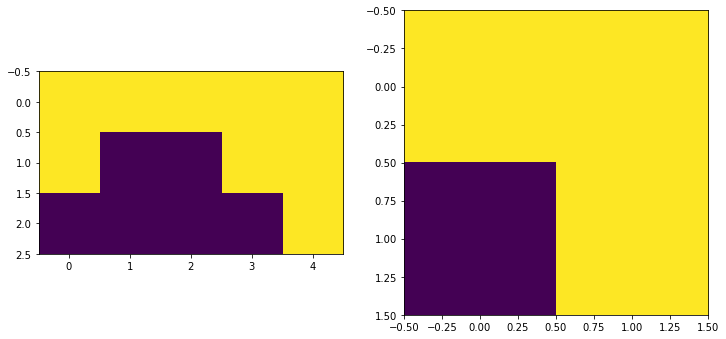

  --> reward:  0
T =  1


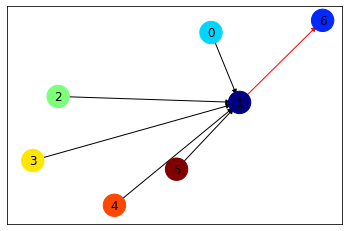

Place:  0  next to  1 position:  left
Scene after move: 


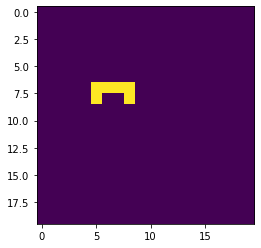

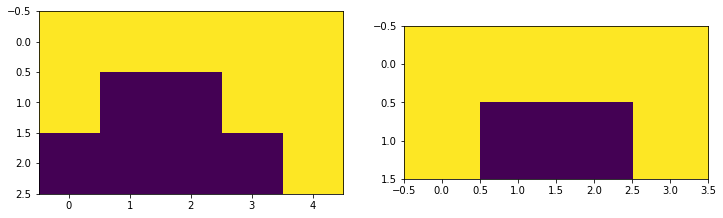

  --> reward:  6
T =  2


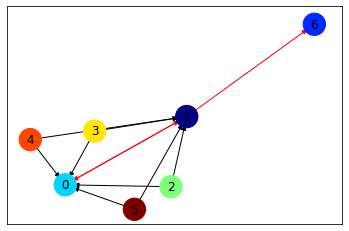

Place:  2  next to  0 position:  left
Scene after move: 


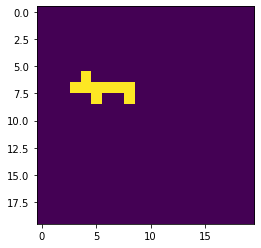

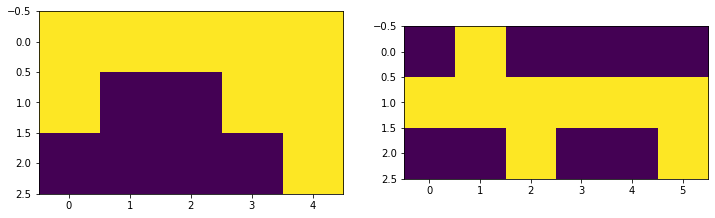

  --> reward:  4


  ###  Test  7  ###
Silhouette


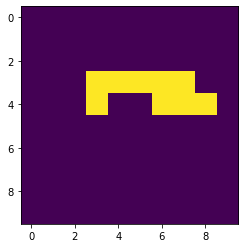

T =  0


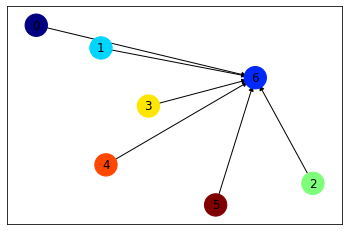

Place:  1
Scene after move: 


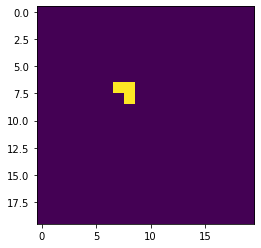

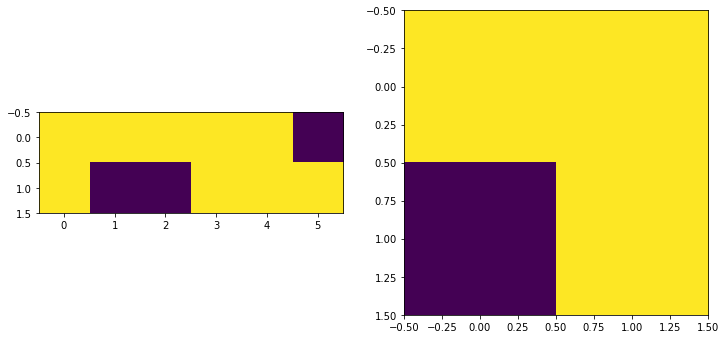

  --> reward:  0
T =  1


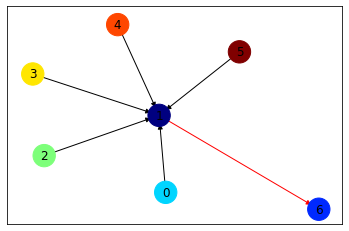

Place:  0  next to  1 position:  left
Scene after move: 


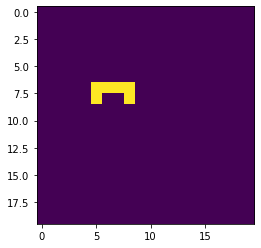

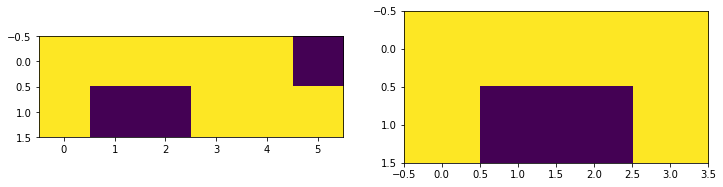

  --> reward:  6
T =  2


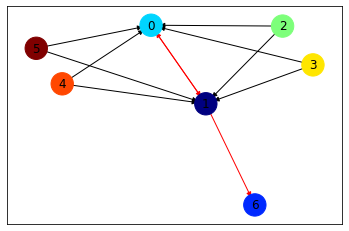

Place:  2  next to  0 position:  left
Scene after move: 


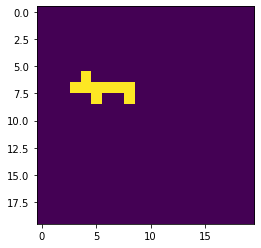

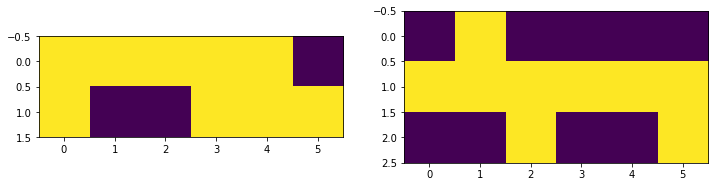

  --> reward:  5


  ###  Test  8  ###
Silhouette


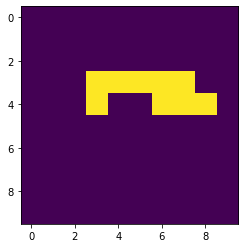

T =  0


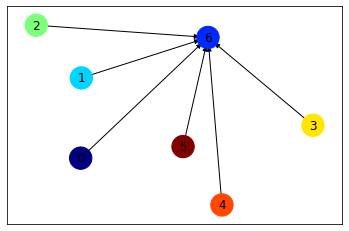

Place:  1
Scene after move: 


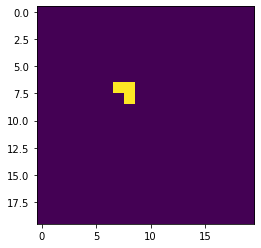

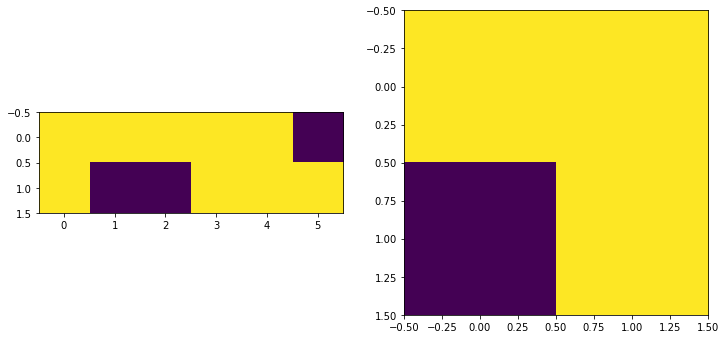

  --> reward:  0
T =  1


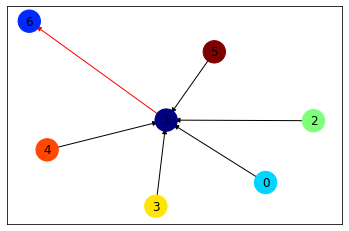

Place:  0  next to  1 position:  left
Scene after move: 


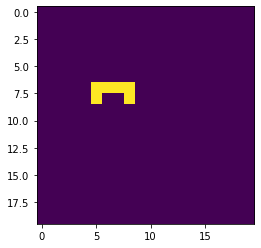

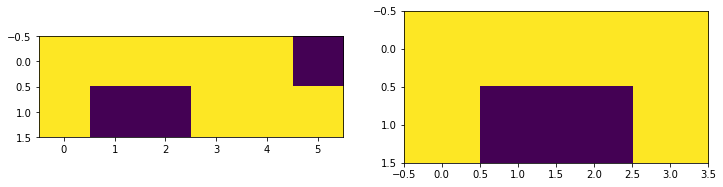

  --> reward:  6
T =  2


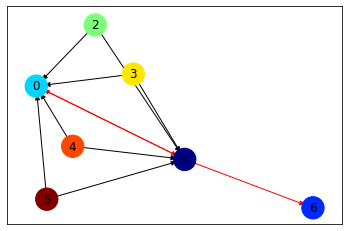

Place:  2  next to  0 position:  left
Scene after move: 


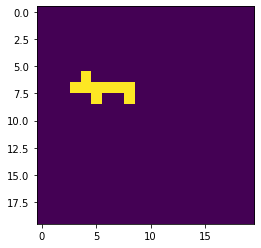

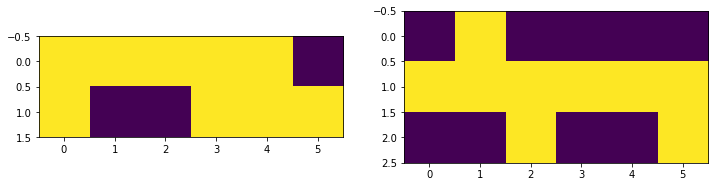

  --> reward:  5


  ###  Test  9  ###
Silhouette


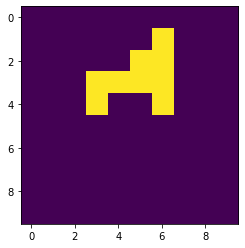

T =  0


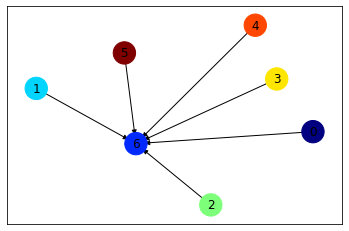

Place:  1
Scene after move: 


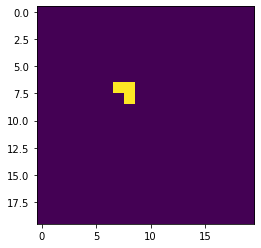

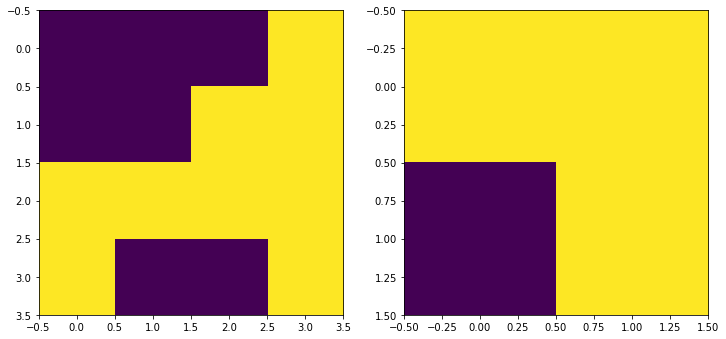

  --> reward:  0
T =  1


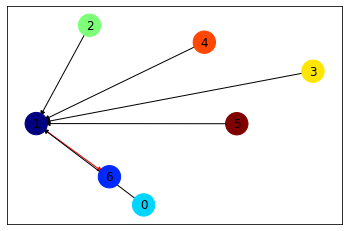

Place:  0  next to  1 position:  left
Scene after move: 


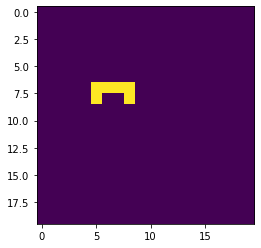

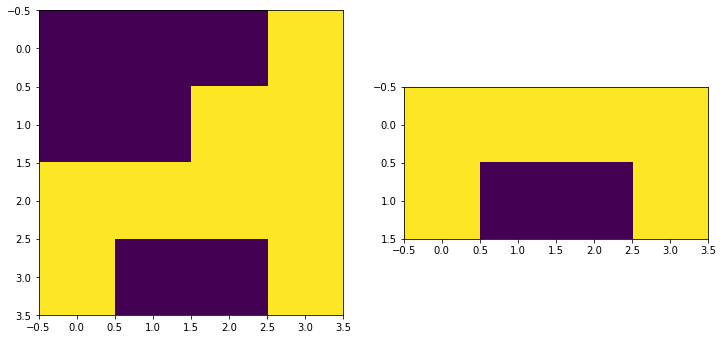

  --> reward:  2
T =  2


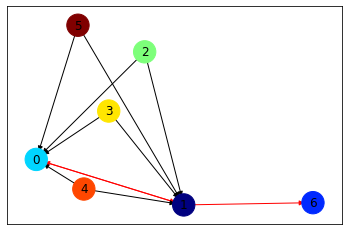

Place:  2  next to  0 position:  left
Scene after move: 


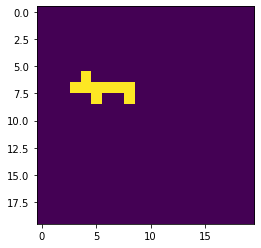

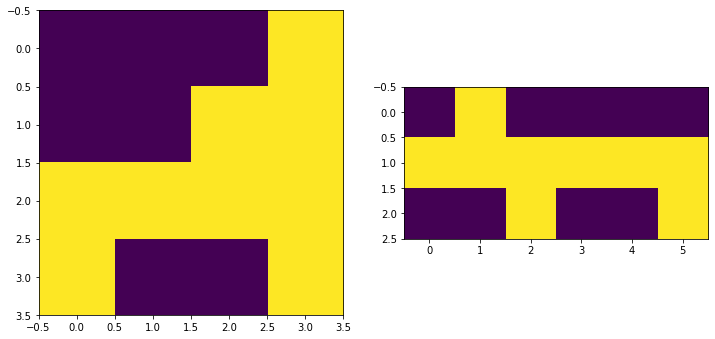

  --> reward:  3


  ###  Test  10  ###
Silhouette


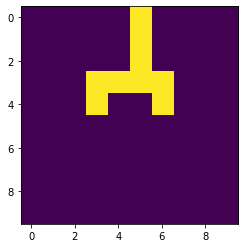

T =  0


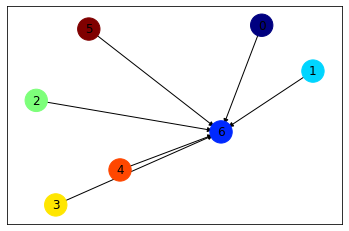

Place:  1
Scene after move: 


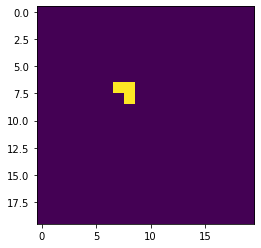

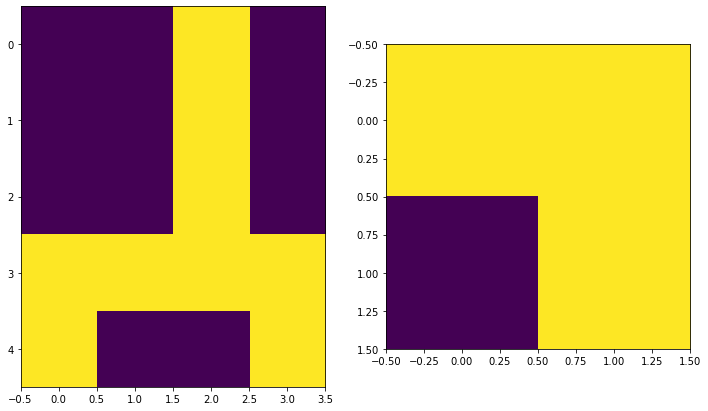

  --> reward:  0
T =  1


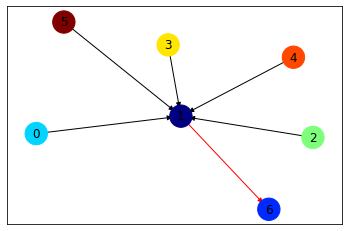

Place:  0  next to  1 position:  left
Scene after move: 


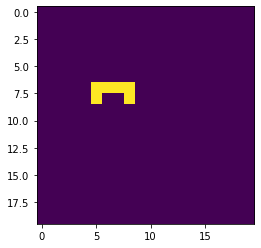

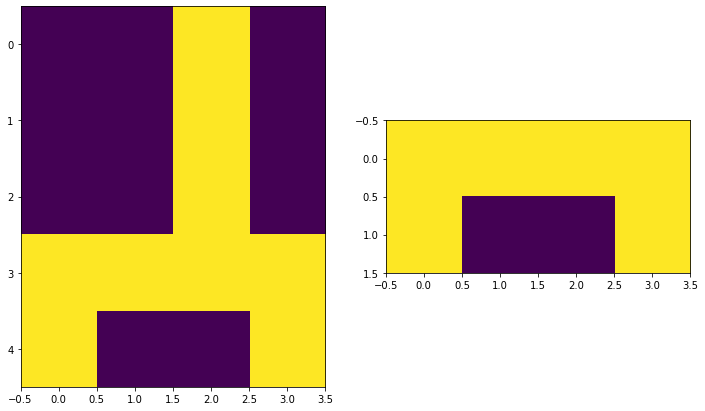

  --> reward:  1
T =  2


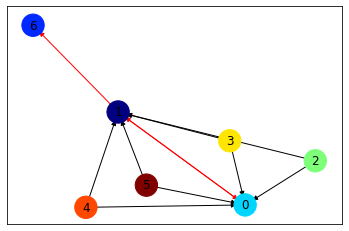

Place:  2  next to  0 position:  left
Scene after move: 


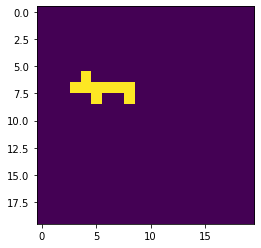

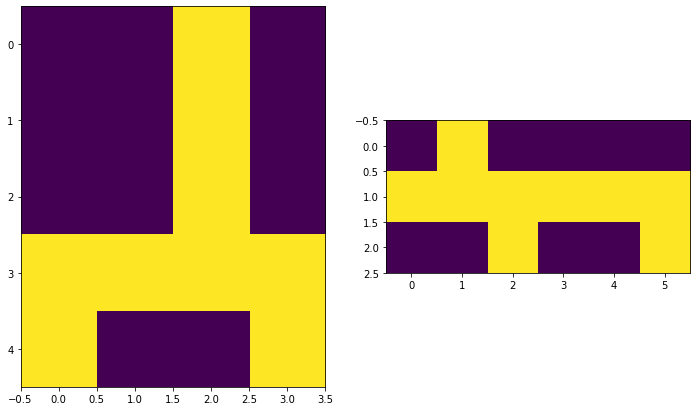

  --> reward:  2


  ###  Test  11  ###
Silhouette


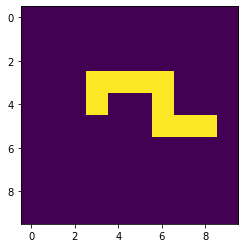

T =  0


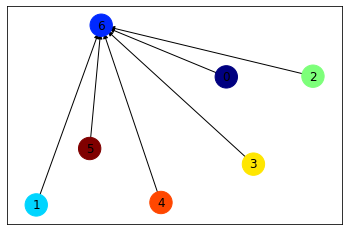

Place:  1
Scene after move: 


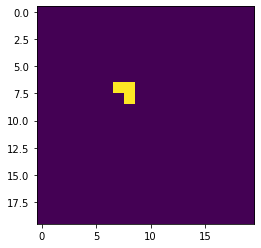

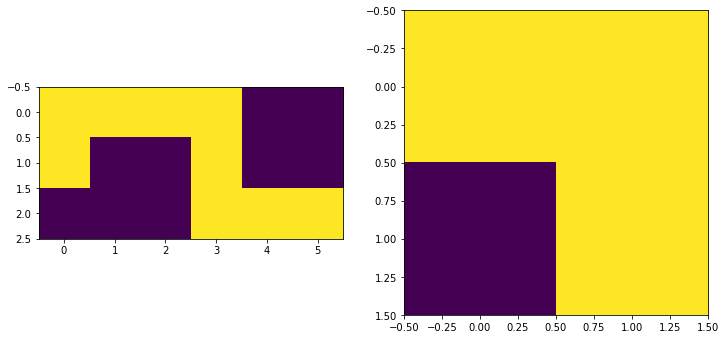

  --> reward:  0
T =  1


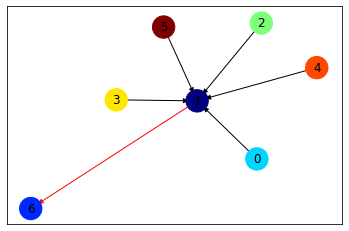

Place:  0  next to  1 position:  left
Scene after move: 


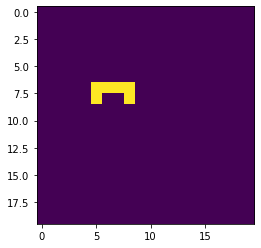

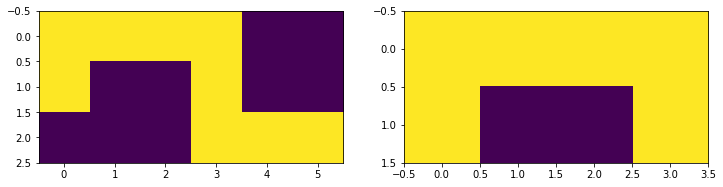

  --> reward:  6
T =  2


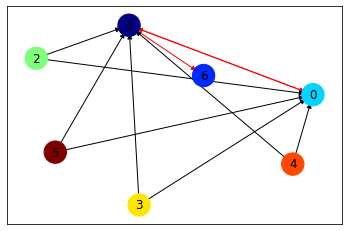

Place:  2  next to  0 position:  left
Scene after move: 


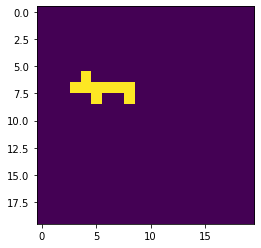

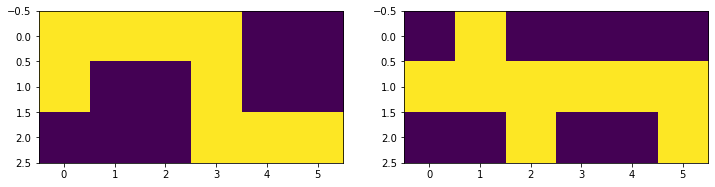

  --> reward:  4


  ###  Test  12  ###
Silhouette


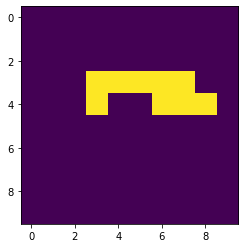

T =  0


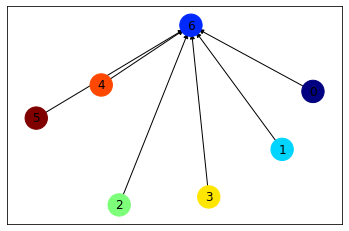

Place:  1
Scene after move: 


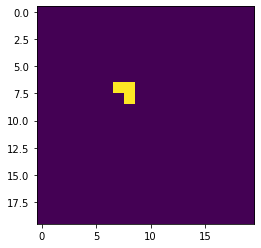

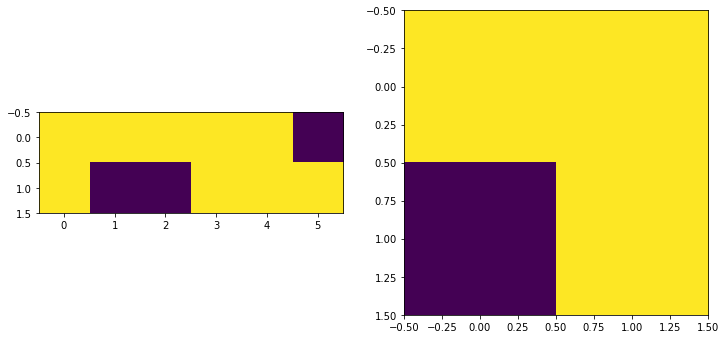

  --> reward:  0
T =  1


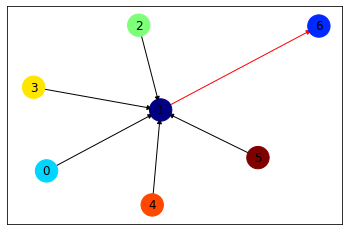

Place:  0  next to  1 position:  left
Scene after move: 


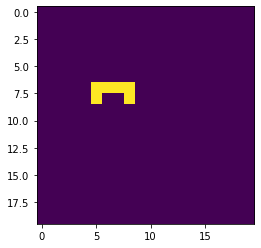

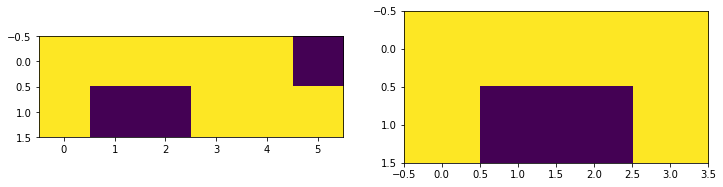

  --> reward:  6
T =  2


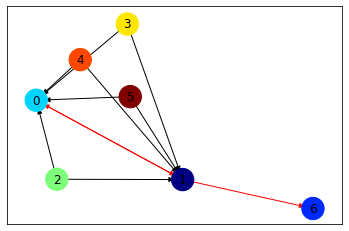

Place:  2  next to  0 position:  left
Scene after move: 


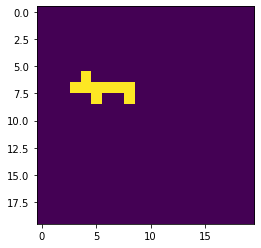

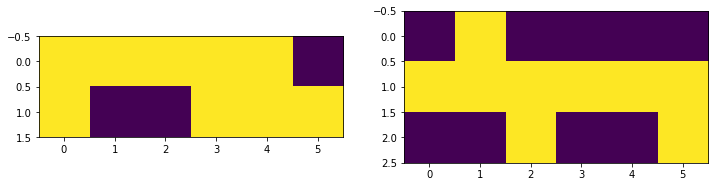

  --> reward:  5


  ###  Test  13  ###
Silhouette


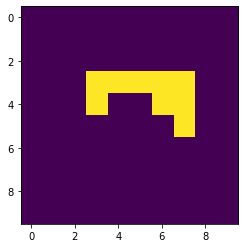

T =  0


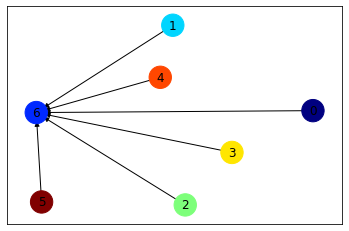

Place:  1
Scene after move: 


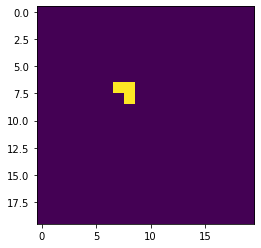

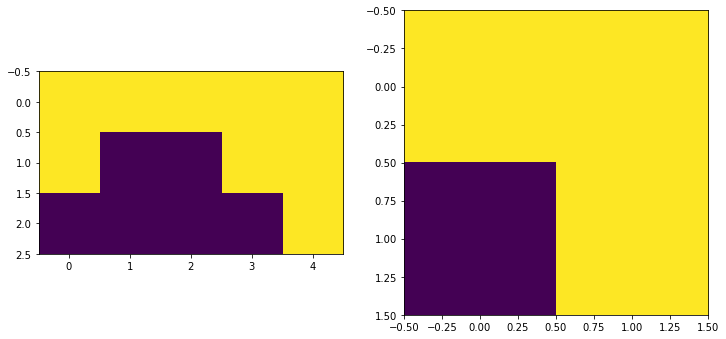

  --> reward:  0
T =  1


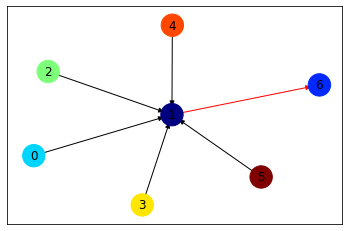

Place:  0  next to  1 position:  left
Scene after move: 


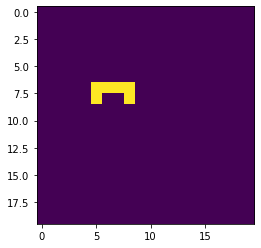

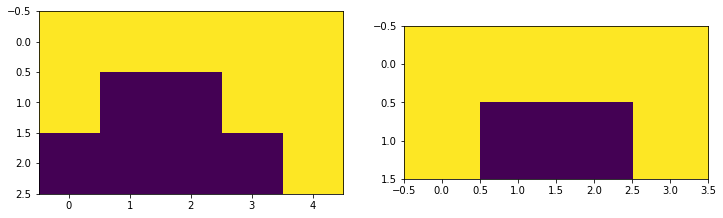

  --> reward:  6
T =  2


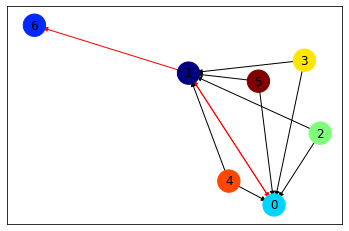

Place:  2  next to  0 position:  left
Scene after move: 


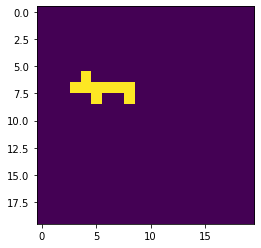

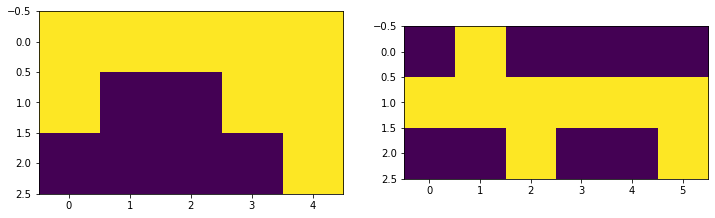

  --> reward:  4


  ###  Test  14  ###
Silhouette


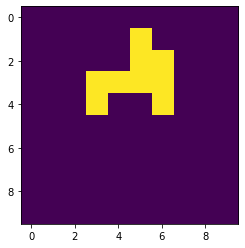

T =  0


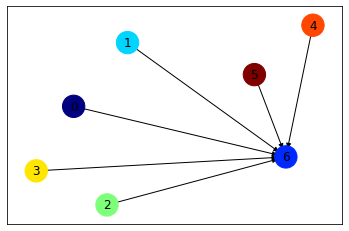

Place:  1
Scene after move: 


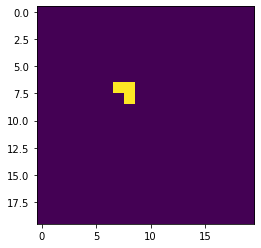

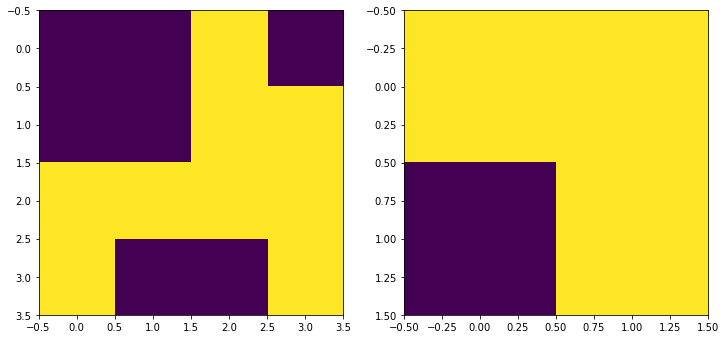

  --> reward:  0
T =  1


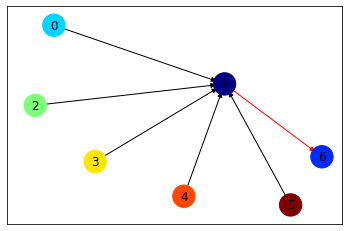

Place:  0  next to  1 position:  left
Scene after move: 


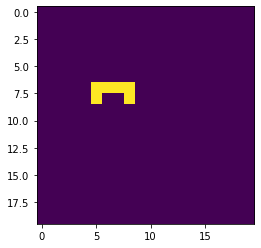

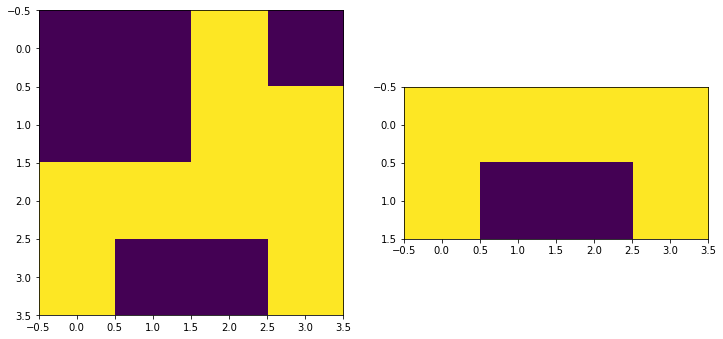

  --> reward:  2
T =  2


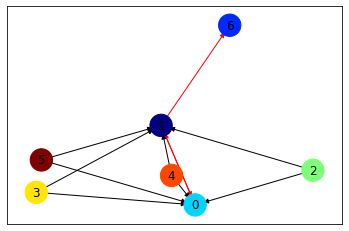

Place:  2  next to  0 position:  left
Scene after move: 


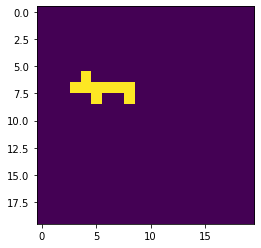

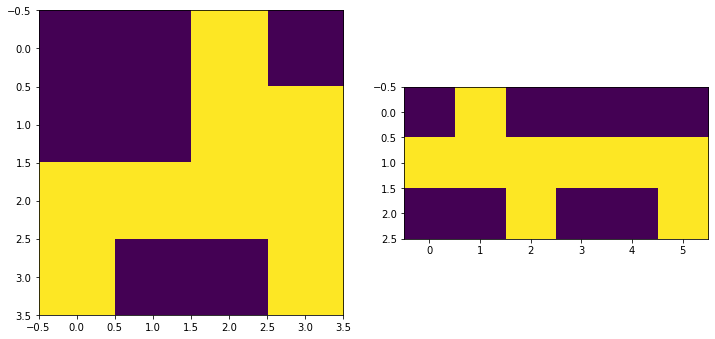

  --> reward:  3


  ###  Test  15  ###
Silhouette


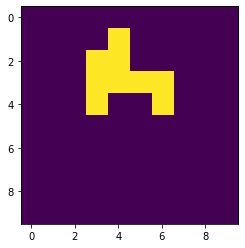

T =  0


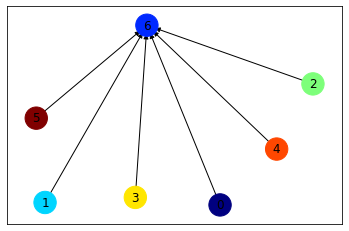

Place:  1
Scene after move: 


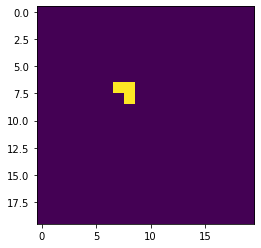

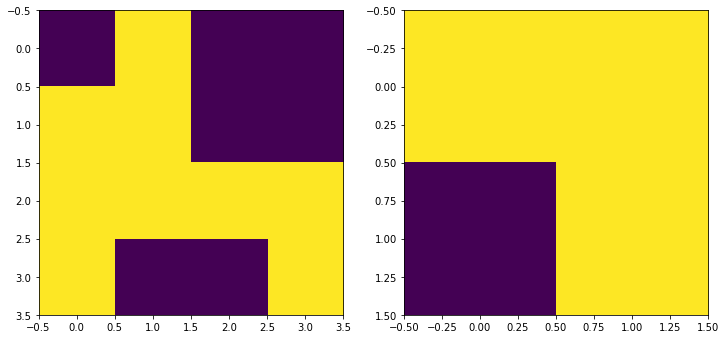

  --> reward:  0
T =  1


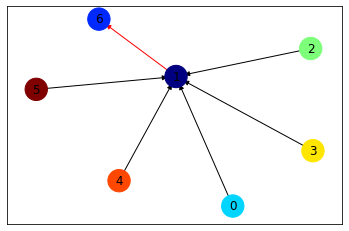

Place:  0  next to  1 position:  left
Scene after move: 


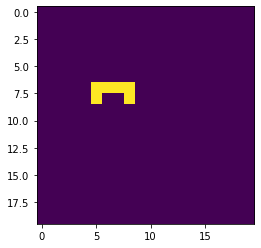

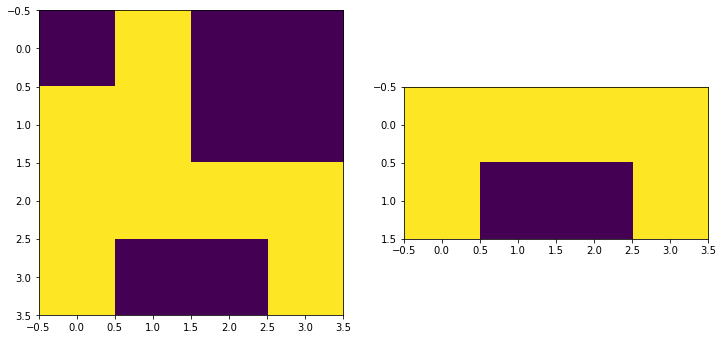

  --> reward:  2
T =  2


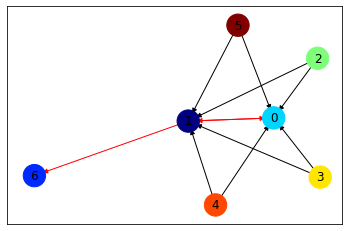

Place:  2  next to  0 position:  left
Scene after move: 


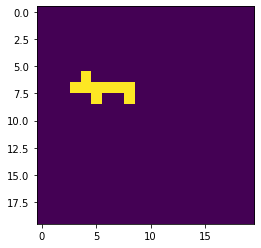

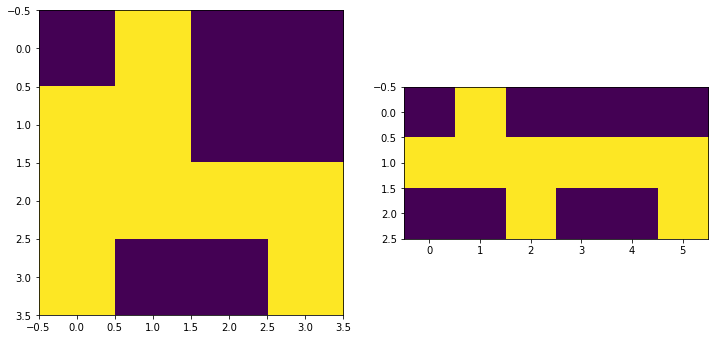

  --> reward:  4


  ###  Test  16  ###
Silhouette


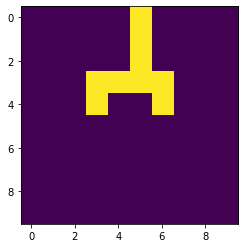

T =  0


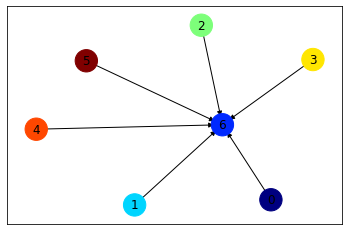

Place:  1
Scene after move: 


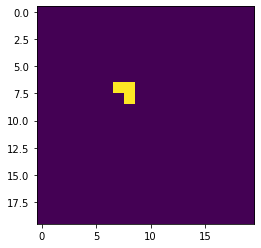

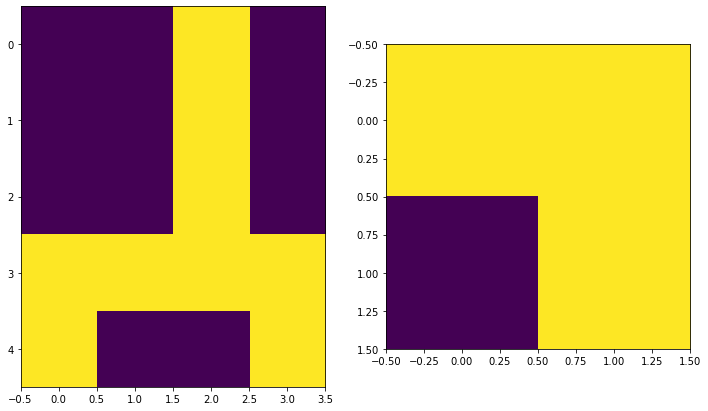

  --> reward:  0
T =  1


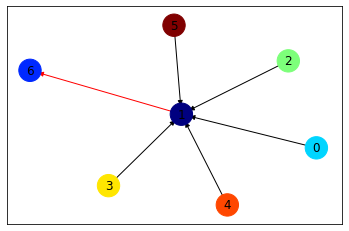

Place:  0  next to  1 position:  left
Scene after move: 


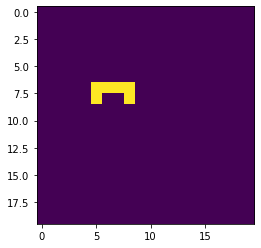

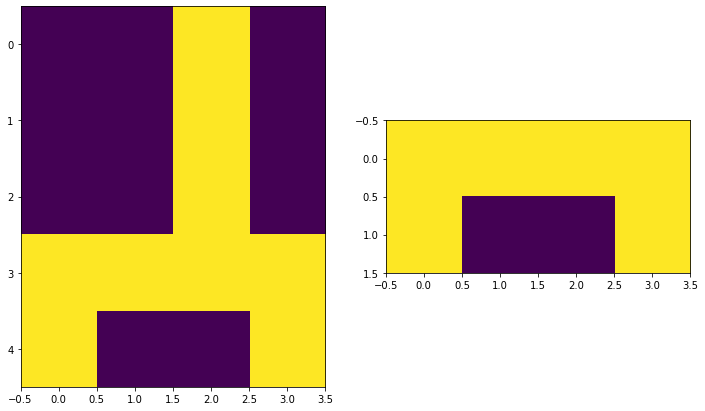

  --> reward:  1
T =  2


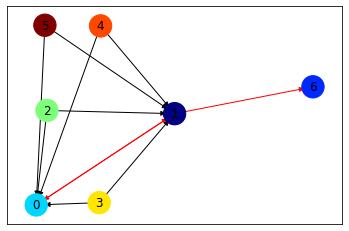

Place:  2  next to  0 position:  left
Scene after move: 


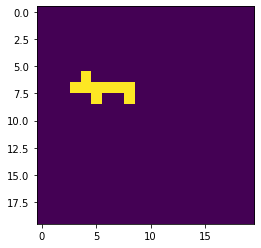

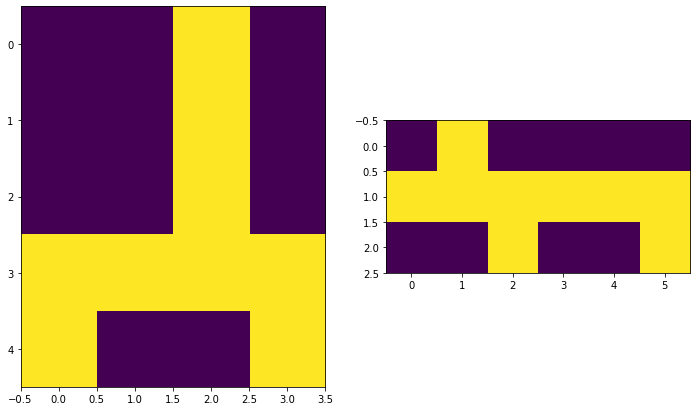

  --> reward:  2


  ###  Test  17  ###
Silhouette


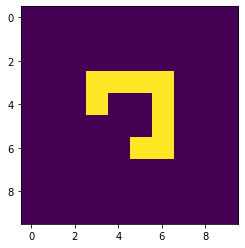

T =  0


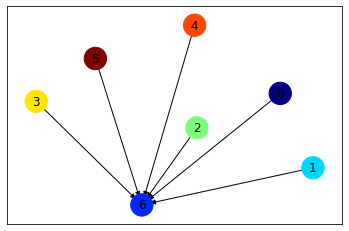

Place:  1
Scene after move: 


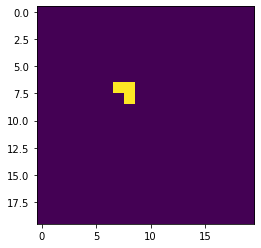

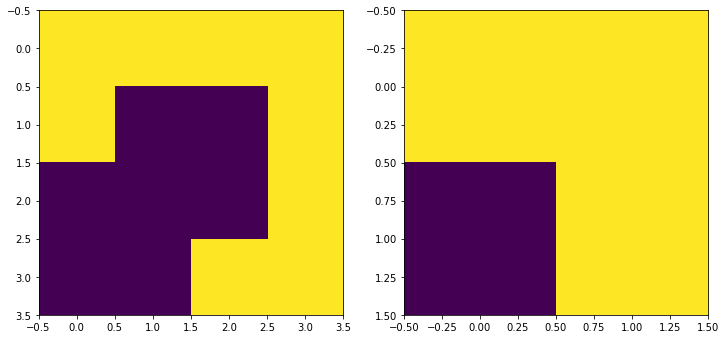

  --> reward:  0
T =  1


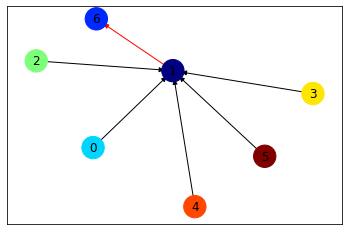

Place:  0  next to  1 position:  left
Scene after move: 


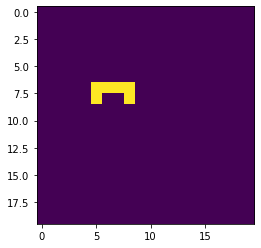

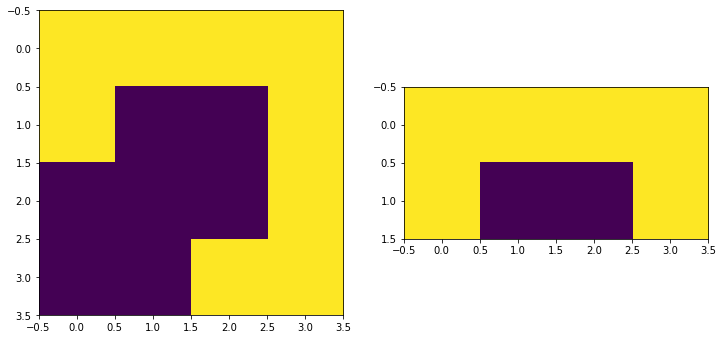

  --> reward:  6
T =  2


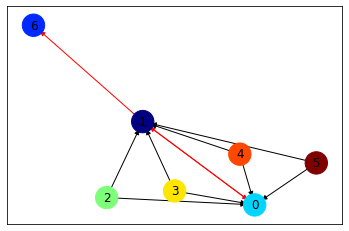

Place:  2  next to  0 position:  left
Scene after move: 


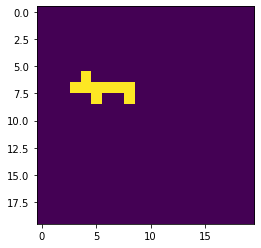

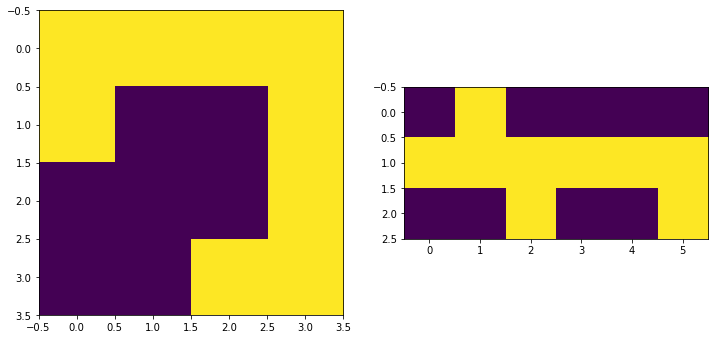

  --> reward:  3


  ###  Test  18  ###
Silhouette


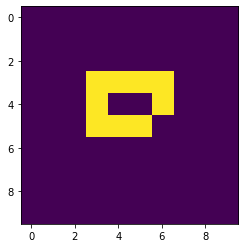

T =  0


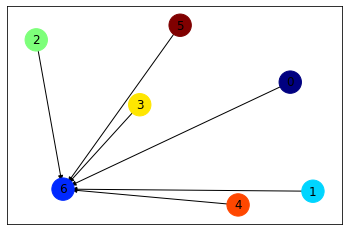

Place:  1
Scene after move: 


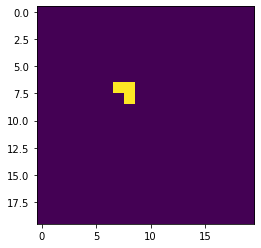

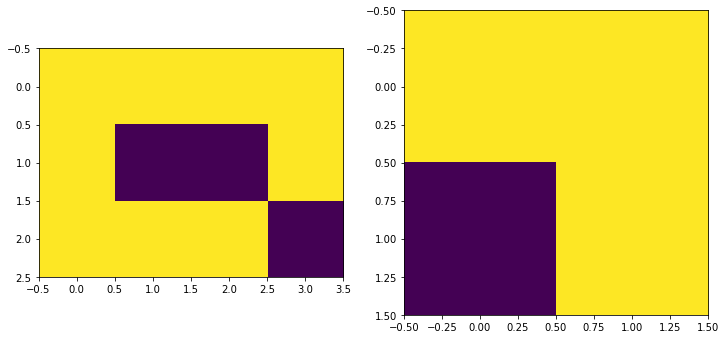

  --> reward:  0
T =  1


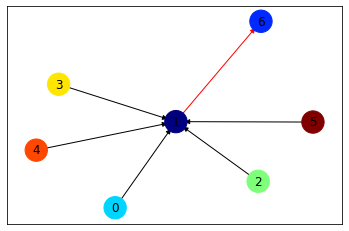

Place:  0  next to  1 position:  left
Scene after move: 


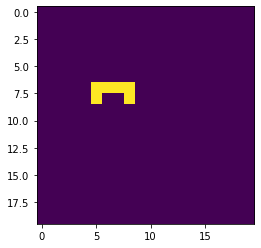

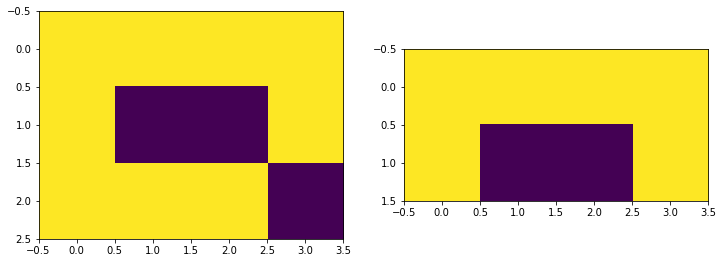

  --> reward:  6
T =  2


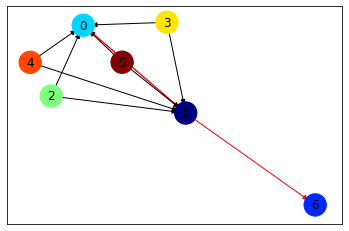

Place:  2  next to  0 position:  left
Scene after move: 


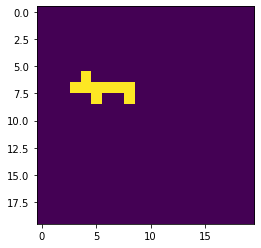

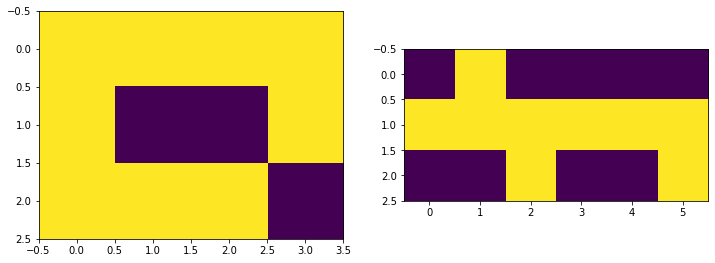

  --> reward:  4


  ###  Test  19  ###
Silhouette


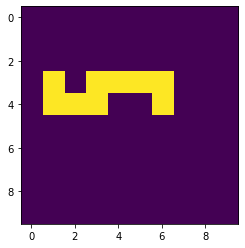

T =  0


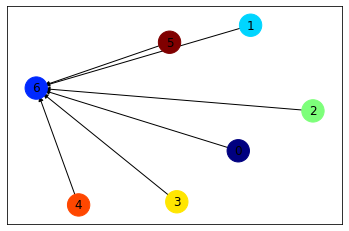

Place:  1
Scene after move: 


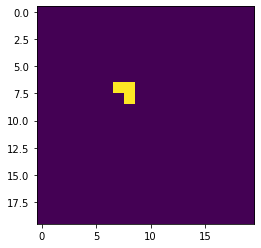

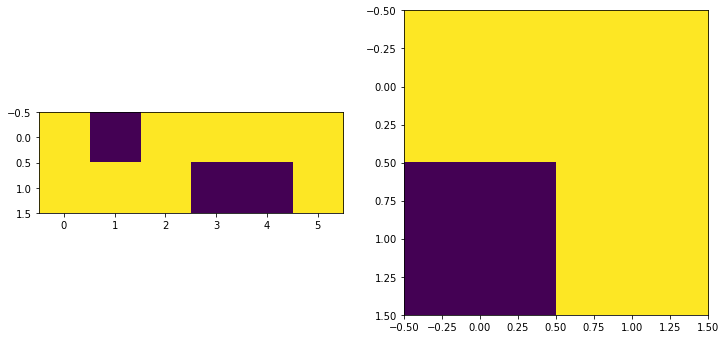

  --> reward:  0
T =  1


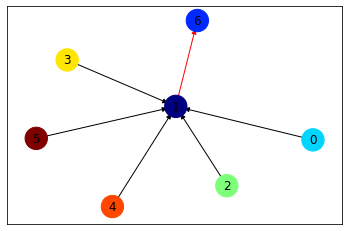

Place:  0  next to  1 position:  left
Scene after move: 


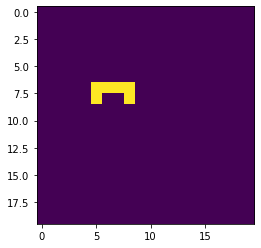

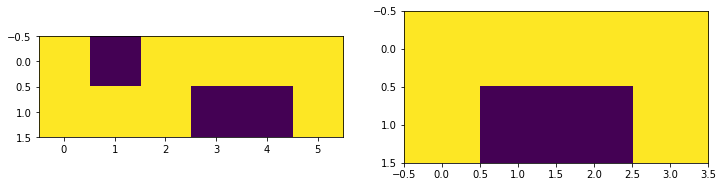

  --> reward:  4
T =  2


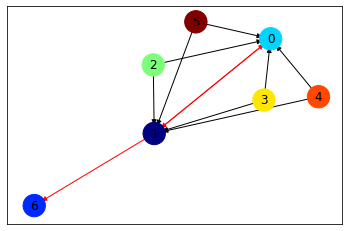

Place:  2  next to  0 position:  left
Scene after move: 


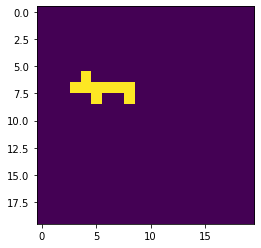

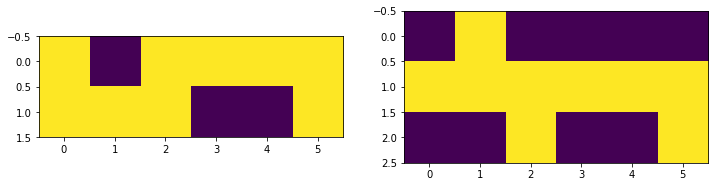

  --> reward:  4


In [324]:
#agent = Agent()
#agent.load("train/model_99000_0.0.pt")
agent.epsilon = 0
env = Env(silhouettes)
g = env.reset()
verbose = True

for i in range(20):
    state = env.reset()
    done = False
    total_reward = 0
    
    print("\n\n  ###  Test ", i, " ###")
    print("Silhouette")
    silhouette = state[2]
    plt.imshow(silhouette)
    plt.show()

    
    while not done:
        sender,receiver,rel_pos = agent.choose_action(state, verbose = False)
        next_state,reward,done = env.step((sender,receiver,rel_pos), verbose)

        total_reward += reward
        print("  --> reward: ", reward)
        state = next_state


